### In this notebook, I practice the sentiment trading strategy with simple moving average crossover strategy using SMA paris as 2 days MA to 5 days MA and 10 days MA to 20 days MA. 

In [36]:
import re
import pandas as pd
from collections import defaultdict 
from datetime import datetime
import datetime
import plotly.express as px
import yfinance as yf
import plotly.graph_objects as go
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt



def agg_to_df(lst):
    df = defaultdict(list)
    for i in range(len(lst)):
        infos = re.split(",|=",str(lst[i]))[:-2]
        for j in range(1,len(infos),2): 
            df[infos[j-1].strip()].append(float(infos[j]))
    df['open'] = df.pop('Agg(open')
    df = pd.DataFrame(df)
    df['timestamp'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x/ 1000.0, tz=datetime.timezone.utc)- datetime.timedelta(hours =5))
    return df

def standardize(data, column):
    data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min()) *100 
    return data

def createFeedsdf(feeds, source, date1, date2):
    #date = 2023-04-16
    date1 = date1 + ' 00:00:00'
    date2 = date2 + ' 23:59:59'
    
    res = feeds[(feeds['platform'] == source)&(feeds['created_at']>date1)&(feeds['created_at']<date2)].sort_values(by=['created_at']).reset_index(drop = True)

    column = 'total_interactions_count'
    res['interactions_count'] = (res[column] - res[column].min()) / (res[column].max() - res[column].min()) *100  
    return res

def addSourceGraph(feeds, source, fig, color1, color2= 'grey'):
    fig.add_trace(
        go.Scatter(
            x=feeds['created_at'],
            y=feeds['interactions_count'],
            name= source + ' feeds',
            mode='markers+lines',
            opacity=0.6,
            showlegend=True,
            marker=dict(
            color=color1,
            size=5,
            opacity=0.3,
            line=dict(
                color=color2,
                width=2)
            )
        )
    )
    
    
def checkPostURL(feeds, num):
    
    return feeds.iloc[num]['post_url']
analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score
#     print(score)
def buynsell(data,shortSMA ='2_SMA', longSMA = '5_SMA' ):
    Trade_Buy1=[]
    Trade_Sell1=[]
    print("Simple Moving Crossover Strategy to generate trade signals")
    for i in range(len(data)-1):
        if ((data[shortSMA].values[i] < data[longSMA].values[i]) & (data[shortSMA].values[i+1] > data[longSMA].values[i+1])):
            print("Trade Call for {row} is Buy.".format(row=data.index[i].date()))
            Trade_Buy1.append(i)
        elif ((data[shortSMA].values[i] > data[longSMA].values[i]) & (data[shortSMA].values[i+1] < data[longSMA].values[i+1])):
            print("Trade Call for {row} is Sell.".format(row=data.index[i].date()))
            Trade_Sell1.append(i)
    return Trade_Buy1, Trade_Sell1




def showdrop(data, dt,feeds, shortSMA ='2_SMA', longSMA = '5_SMA'):
    
    data1 = data[data.index < dt]
    Trade_Buy, Trade_Sell = buynsell(data1,shortSMA,longSMA)
    plt.figure(figsize=(20, 10),dpi=80)
    plt.plot(data1.index, data1['Close'], color = 'black', linewidth=3.0)
    plt.plot(data1.index, data1[shortSMA],'-^', markevery=Trade_Buy, ms=15, color='green')
    plt.plot(data1.index, data1[longSMA],'-v', markevery=Trade_Sell, ms=15, color='red')
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('Price in Dollars', fontsize = 14)
    plt.xticks(rotation=60,fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Trade Calls - Moving Averages Crossover for BUD', fontsize = 16)
    plt.legend(['Close',shortSMA,longSMA])
    plt.grid()
    plt.show() 
    unique_dates = feeds['date'].unique()
    grouped_dates = feeds.groupby(['date'])
    keys_dates = list(grouped_dates.groups.keys())

    max_cs = []
    min_cs = []

    for key in grouped_dates.groups.keys():
        data = grouped_dates.get_group(key)
        if data["Sentiment Score"].max() > 0:
            max_cs.append(data["Sentiment Score"].max())
        elif data["Sentiment Score"].max() <= 0:
            max_cs.append(0)

        if data["Sentiment Score"].min() < 0:
            min_cs.append(data["Sentiment Score"].min())
        elif data["Sentiment Score"].min() >= 0:
            min_cs.append(0)

    extreme_scores_dict = {'Date':keys_dates,'max_scores':max_cs,'min_scores':min_cs}
    extreme_scores_df = pd.DataFrame(extreme_scores_dict)
    final_scores = []
    for i in range(len(extreme_scores_df)):
        final_scores.append(extreme_scores_df['max_scores'].values[i] + extreme_scores_df['min_scores'].values[i])
    print("VADER sentiment score to generate trading signals")
    extreme_scores_df['final_scores'] = final_scores
    vader_Buy=[]
    vader_Sell=[]
    for i in range(len(extreme_scores_df)):
        if extreme_scores_df['final_scores'].values[i] > 0.20:
            print("Trade Call for {row} is Buy.".format(row=extreme_scores_df['Date'].iloc[i]))
            vader_Buy.append(extreme_scores_df['Date'].iloc[i])
        elif extreme_scores_df['final_scores'].values[i] < -0.20:
            print("Trade Call for {row} is Sell.".format(row=extreme_scores_df['Date'].iloc[i]))
            vader_Sell.append(extreme_scores_df['Date'].iloc[i])
    vader_buy = []
    for i in range(len(data1)):
        if data1.index[i].date() in vader_Buy:
            vader_buy.append(i)

    vader_sell = []
    for i in range(len(data1)):
        if data1.index[i].date() in vader_Sell:
            vader_sell.append(i)
    print("Using VADER sentiment")

    plt.figure(figsize=(20, 10),dpi=80)
    plt.plot(data1.index, data1['Close'],'-^', markevery=vader_buy, ms=15, color='green')
    plt.plot(data1.index, data1['Close'],'-v', markevery=vader_sell, ms=15, color='red')
    plt.plot(data1.index, data1['Close'], color = 'black',linewidth=3.0)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('Price in Dollars', fontsize = 14)
    plt.xticks(rotation=60,fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Trade Calls - VADER', fontsize = 16)
    plt.legend(['Buy','Sell','Close'])
    plt.grid()
    plt.show() 
    print("Using VADER sentiment and the simple moving average strategy")
    final_buy = list(set(Trade_Buy + vader_buy) - set(Trade_Sell)) 
    final_sell = list(set(Trade_Sell + vader_sell) - set(Trade_Buy))

    plt.figure(figsize=(20, 10),dpi=80)
    plt.plot(data1.index, data1[shortSMA], color='green')
    plt.plot(data1.index, data1[longSMA], color='red')
    plt.plot(data1.index, data1['Close'],'-^', markevery=final_buy, ms=15, color='green')
    plt.plot(data1.index, data1['Close'],'-v', markevery=final_sell, ms=15, color='red')
    plt.plot(data1.index, data1['Close'], color = 'black',linewidth=3.0)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('Price in Dollars', fontsize = 14)
    plt.xticks(rotation=60,fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('Trade Calls - MERGED', fontsize = 16)
    plt.legend([shortSMA,longSMA,'Buy','Sell','Close'])
    plt.grid()
    plt.show() 

In [2]:
# #polygon.io 
# from polygon import RESTClient
# from datetime import datetime

# client = RESTClient(api_key="8YSJW92Yz2CtBBAbyNad1HO0p_yurThH")
# ticker = "BUD"

In [3]:
# #for the first drop: 
# aggs0403_0406 = []
# for a in client.list_aggs(ticker=ticker, multiplier=1, timespan="minute", from_="2023-03-31", to="2023-04-06", limit=50000):
#     aggs0403_0406.append(a)
    
    

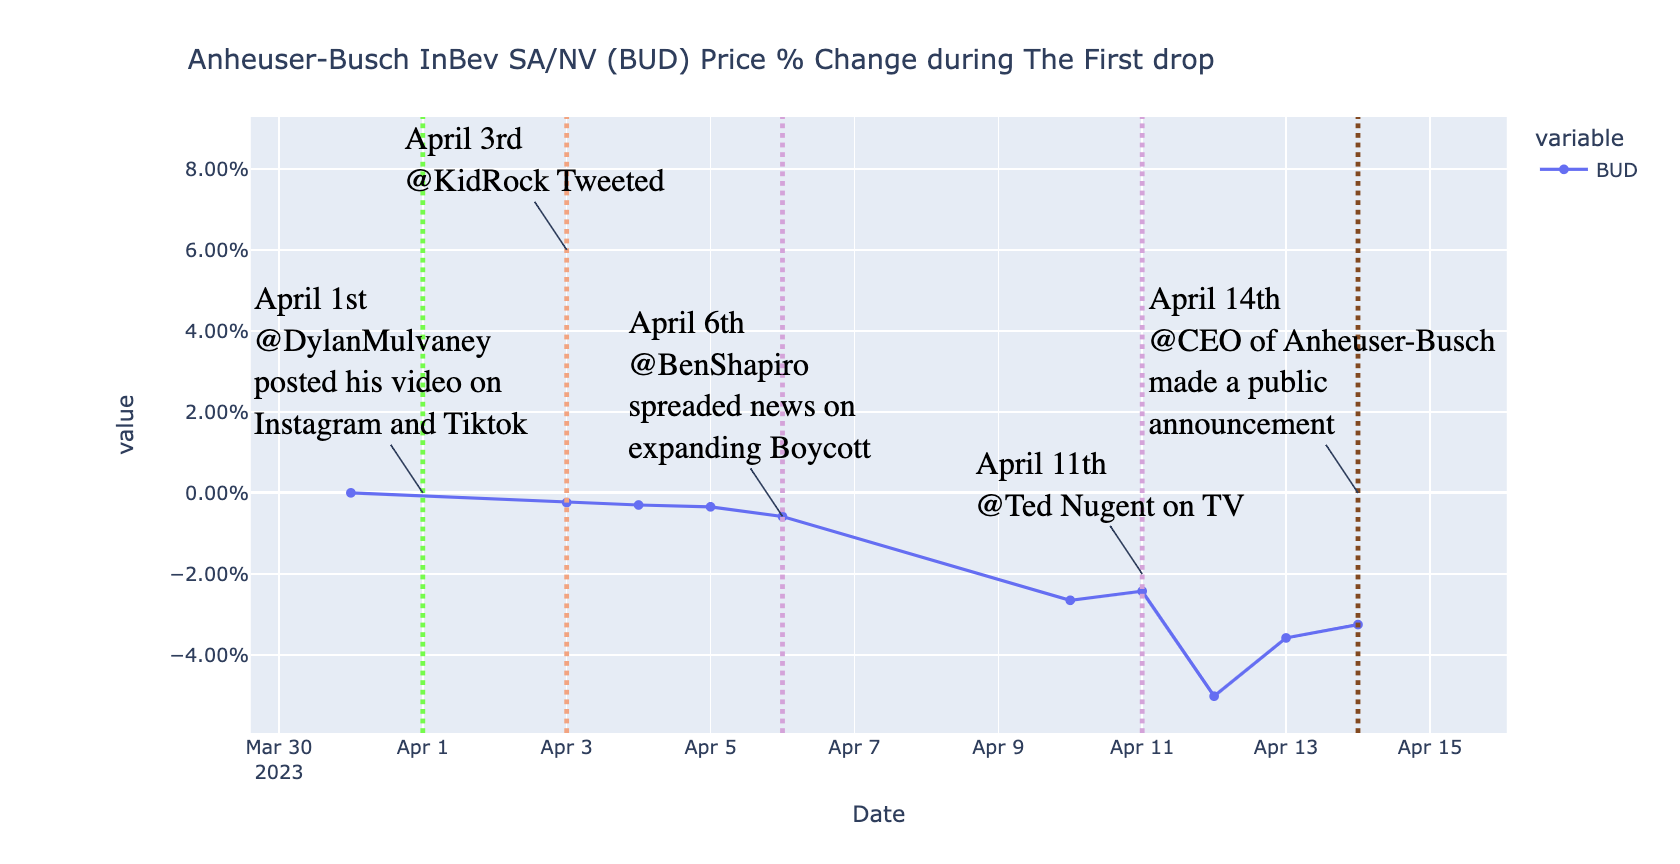

Sentiment Analysis method: VADER

VADER: VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER uses a combination of A sentiment lexicon is a list of lexical features (e.g., words) which are generally labelled according to their semantic orientation as either positive or negative.


Valence score is measured on a scale from -1 to +1, where -1 stands for the most ‘Negative’ sentiment and +1 for the most ‘Positive’ sentiment. Intuitively one can guess that midpoint 0 represents ‘Neutral’ Sentiment, and this is how it is defined actually too.


Refs:

Github: https://github.com/cjhutto/vaderSentiment

Paper: https://ojs.aaai.org/index.php/ICWSM/article/view/14550/14399

practice: https://blog.quantinsti.com/vader-sentiment/

In [4]:
data = yf.download(tickers="BUD", start = "2023-03-25", end = "2023-06-01", interval="1d")
column = 'Close'
# data['Close'] = (data[column] - data[column].min()) / (data[column].max() - data[column].min()) *100 
data['Change'] = data['Close'].apply( lambda x: ((x - data.iloc[1]['Close']) / data.iloc[1]['Close'])) 

[*********************100%***********************]  1 of 1 completed


In [5]:
# Simple Moving Crossover Strategy to generate trade calls
#Strategy: when short moving average crosses above the long moving average, then it is a buy signal and vice versa

data['2_SMA'] = data['Close'].rolling(window=2).mean()
data['5_SMA'] = data['Close'].rolling(window=5).mean()

data = data[data['5_SMA'].notna()]

# SMA trade calls
Trade_Buy=[]
Trade_Sell=[]
for i in range(len(data)-1):
    if ((data['2_SMA'].values[i] < data['5_SMA'].values[i]) & (data['2_SMA'].values[i+1] > data['5_SMA'].values[i+1])):
        print("Trade Call for {row} is Buy.".format(row=data.index[i].date()))
        Trade_Buy.append(i)
    elif ((data['2_SMA'].values[i] > data['5_SMA'].values[i]) & (data['2_SMA'].values[i+1] < data['5_SMA'].values[i+1])):
        print("Trade Call for {row} is Sell.".format(row=data.index[i].date()))
        Trade_Sell.append(i)

Trade Call for 2023-04-04 is Sell.
Trade Call for 2023-04-14 is Buy.
Trade Call for 2023-04-27 is Sell.
Trade Call for 2023-05-03 is Buy.
Trade Call for 2023-05-08 is Sell.
Trade Call for 2023-05-19 is Buy.
Trade Call for 2023-05-22 is Sell.


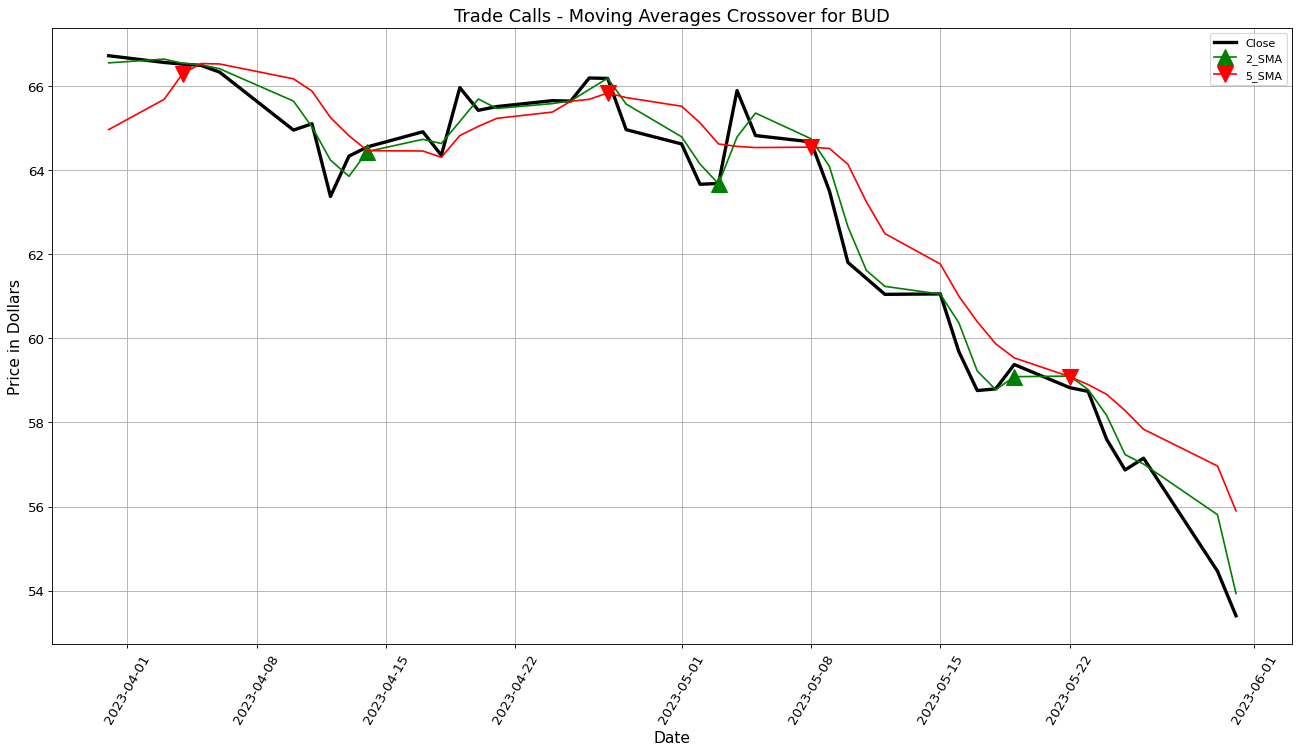

In [6]:
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(data.index, data['Close'], color='black',linewidth=3.0)
plt.plot(data.index, data['2_SMA'],'-^', markevery=Trade_Buy, ms=15, color='green')
plt.plot(data.index, data['5_SMA'],'-v', markevery=Trade_Sell, ms=15, color='red')
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation=60,fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - Moving Averages Crossover for BUD', fontsize = 16)
plt.legend(['Close','2_SMA','5_SMA'])
plt.grid()
plt.show() 

In [27]:
#use 10 and 20 days sma
data2 = yf.download(tickers="BUD", start = "2021-03-25", end = "2023-06-01", interval="1d")
column = 'Close'
# data['Close'] = (data[column] - data[column].min()) / (data[column].max() - data[column].min()) *100 
data2['Change'] = data2['Close'].apply( lambda x: ((x - data2.iloc[1]['Close']) / data2.iloc[1]['Close'])) 

# Simple Moving Crossover Strategy to generate trade calls
#Strategy: when short moving average crosses above the long moving average, then it is a buy signal and vice versa

data2['10_SMA'] = data2['Close'].rolling(window=10).mean()
data2['20_SMA'] = data2['Close'].rolling(window=20).mean()

data2 = data2[data2['20_SMA'].notna()]

# SMA trade calls
Trade_Buy=[]
Trade_Sell=[]
for i in range(len(data2)-1):
    if ((data2['10_SMA'].values[i] < data2['20_SMA'].values[i]) & (data2['10_SMA'].values[i+1] > data2['20_SMA'].values[i+1])):
        print("Trade Call for {row} is Buy.".format(row=data2.index[i].date()))
        Trade_Buy.append(i)
    elif ((data2['10_SMA'].values[i] > data2['20_SMA'].values[i]) & (data2['10_SMA'].values[i+1] < data2['20_SMA'].values[i+1])):
        print("Trade Call for {row} is Sell.".format(row=data2.index[i].date()))
        Trade_Sell.append(i)


[*********************100%***********************]  1 of 1 completed
Trade Call for 2021-06-23 is Sell.
Trade Call for 2021-10-25 is Buy.
Trade Call for 2021-11-19 is Sell.
Trade Call for 2021-12-15 is Buy.
Trade Call for 2022-01-31 is Sell.
Trade Call for 2022-02-23 is Buy.
Trade Call for 2022-03-01 is Sell.
Trade Call for 2022-03-23 is Buy.
Trade Call for 2022-04-11 is Sell.
Trade Call for 2022-05-26 is Buy.
Trade Call for 2022-05-31 is Sell.
Trade Call for 2022-06-01 is Buy.
Trade Call for 2022-06-09 is Sell.
Trade Call for 2022-07-01 is Buy.
Trade Call for 2022-07-28 is Sell.
Trade Call for 2022-08-15 is Buy.
Trade Call for 2022-08-23 is Sell.
Trade Call for 2022-09-19 is Buy.
Trade Call for 2022-09-23 is Sell.
Trade Call for 2022-10-21 is Buy.
Trade Call for 2023-01-20 is Sell.
Trade Call for 2023-02-23 is Buy.
Trade Call for 2023-03-16 is Sell.
Trade Call for 2023-03-23 is Buy.
Trade Call for 2023-04-20 is Sell.
Trade Call for 2023-04-28 is Buy.
Trade Call for 2023-05-08 is Sell.

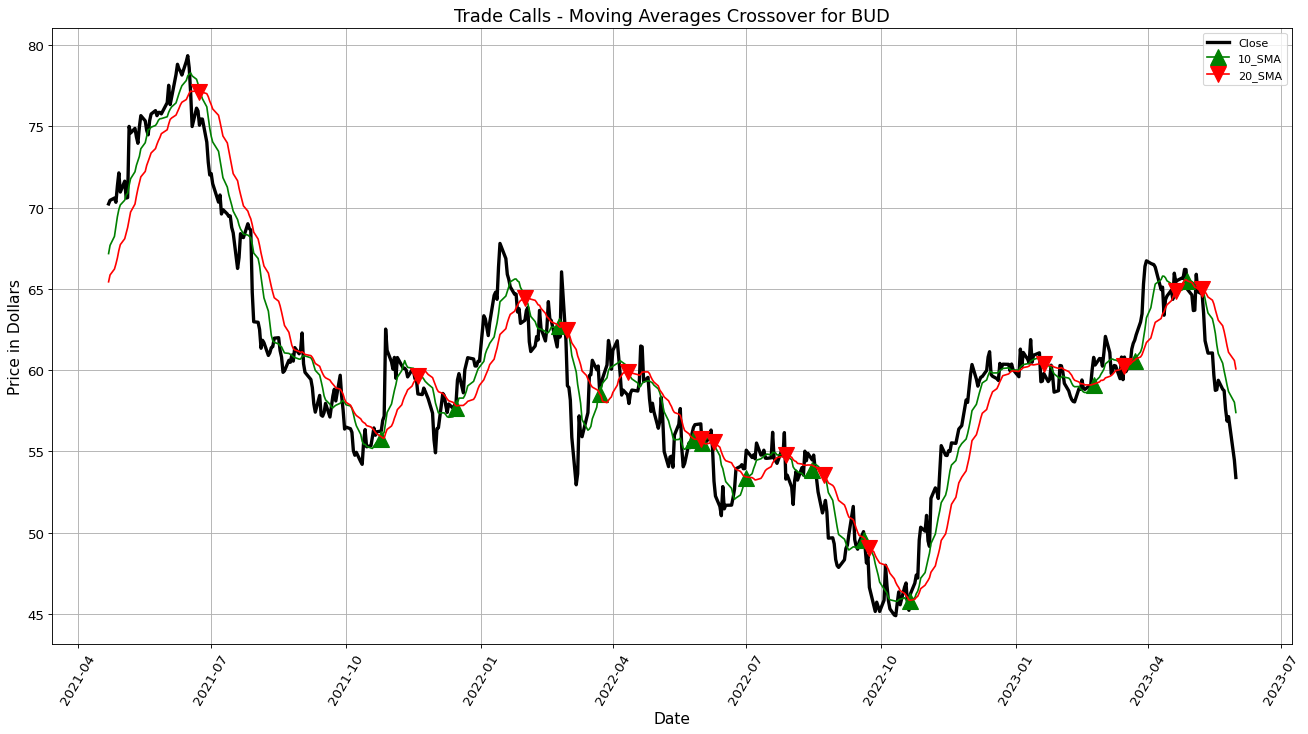

In [28]:
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(data2.index, data2['Close'], color='black',linewidth=3.0)
plt.plot(data2.index, data2['10_SMA'],'-^', markevery=Trade_Buy, ms=15, color='green')
plt.plot(data2.index, data2['20_SMA'],'-v', markevery=Trade_Sell, ms=15, color='red')
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation=60,fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - Moving Averages Crossover for BUD', fontsize = 16)
plt.legend(['Close','10_SMA','20_SMA'])
plt.grid()
plt.show() 

In [39]:
data2

,Open,High,Low,Close,Adj Close,Volume,Change,10_SMA,20_SMA
Date,,,,,,,,,
2021-04-22,70.080002,70.650002,69.959999,70.230003,68.082825,1204200,0.109303,67.175000,65.438500
2021-04-23,69.790001,70.760002,69.760002,70.449997,68.296089,830000,0.112778,67.681000,65.859000
2021-04-26,70.000000,70.739998,70.000000,70.589996,68.431816,610800,0.114990,68.232999,66.222999
2021-04-27,70.029999,70.489998,69.860001,70.330002,68.179764,738900,0.110883,68.828000,66.534500
2021-04-28,71.680000,71.830002,71.230003,71.330002,69.149200,1227300,0.126678,69.445000,66.902000
...,...,...,...,...,...,...,...,...,...
2023-05-24,57.439999,57.910000,57.410000,57.599998,57.599998,2923100,-0.090191,59.534000,61.961000
2023-05-25,56.650002,57.130001,56.630001,56.869999,56.869999,3171100,-0.101722,59.078000,61.495000
2023-05-26,56.900002,57.200001,56.820000,57.150002,57.150002,2333900,-0.097299,58.688000,61.104000


Simple Moving Crossover Strategy to generate trade signals


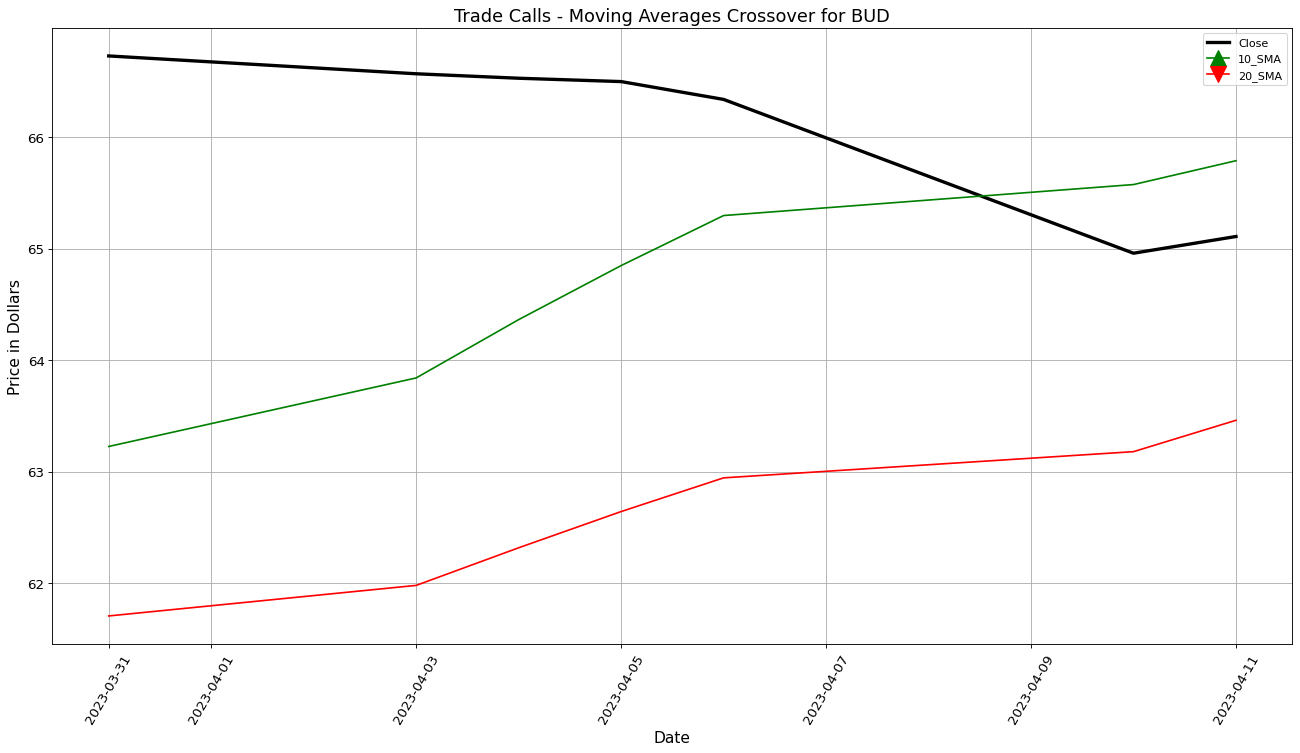

VADER sentiment score to generate trading signals
Trade Call for 2023-04-03 is Sell.
Trade Call for 2023-04-07 is Buy.
Using VADER sentiment


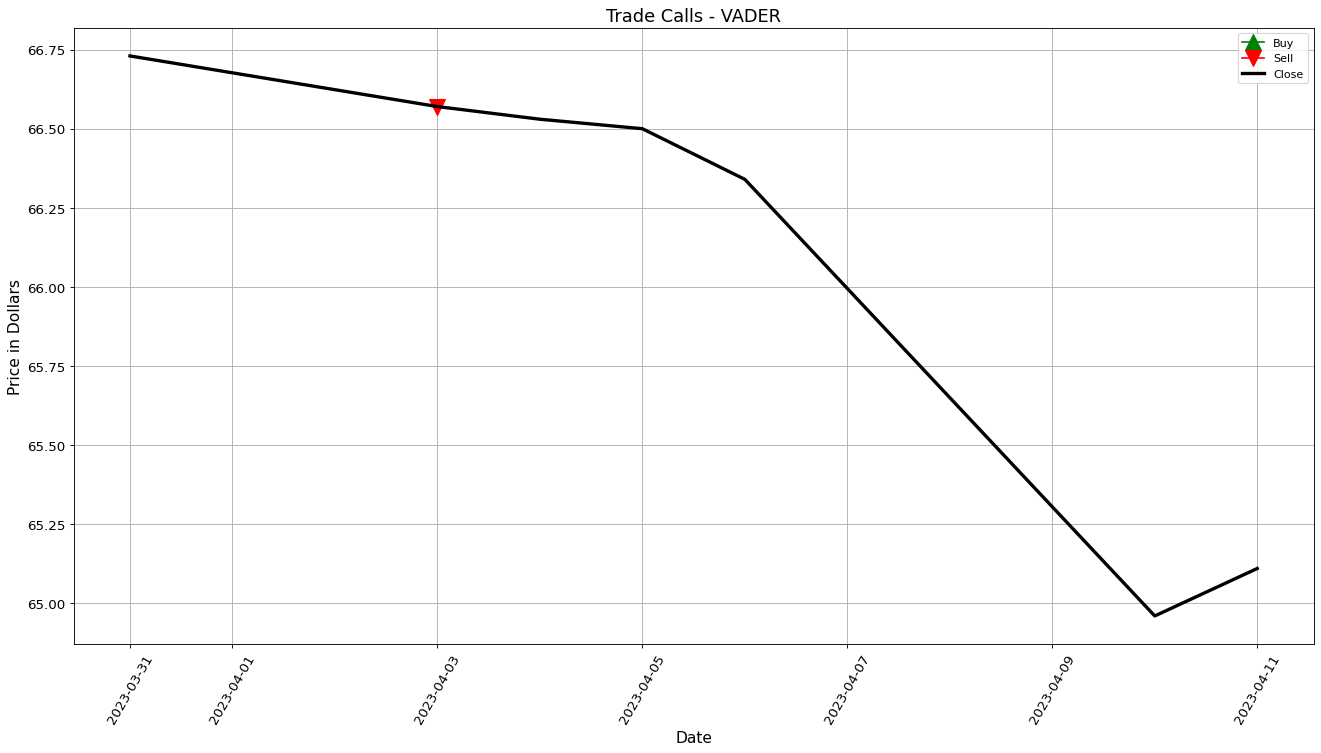

Using VADER sentiment and the simple moving average strategy


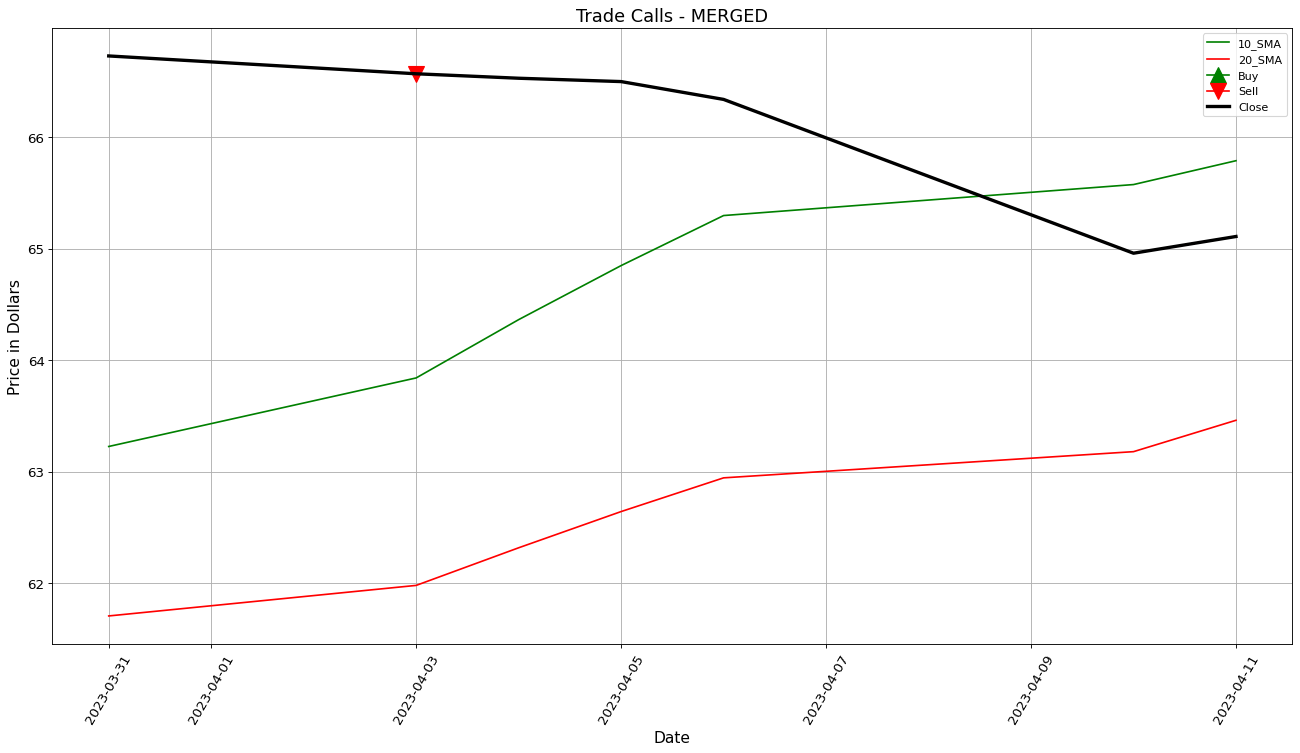

In [42]:
#first drop 
feeds= pd.read_csv("BUD_0331_0412.csv")
feeds['created_at'] = pd.to_datetime(feeds['created_at'])-  pd.to_timedelta(4, unit='h')
feeds = feeds.sort_values(by=['created_at']).reset_index(drop = True)
feeds = feeds[(feeds['text'].notna())& (feeds['platform']=='twitter')].reset_index(drop = True)
n = len(feeds['text'])

compound = []
date = []
for i in range(n):
#     print(i, sentiment_analyzer_scores(feeds['text'][i])['compound'])
    compound.append(sentiment_analyzer_scores(feeds['text'][i])['compound'])
    date.append(feeds['created_at'][i].date())
feeds['Sentiment Score'] = compound
feeds['date'] = date
showdrop(data2[data2.index>='2023-03-31'], '2023-04-12',feeds,'10_SMA','20_SMA')

Simple Moving Crossover Strategy to generate trade signals
Trade Call for 2023-04-04 is Sell.


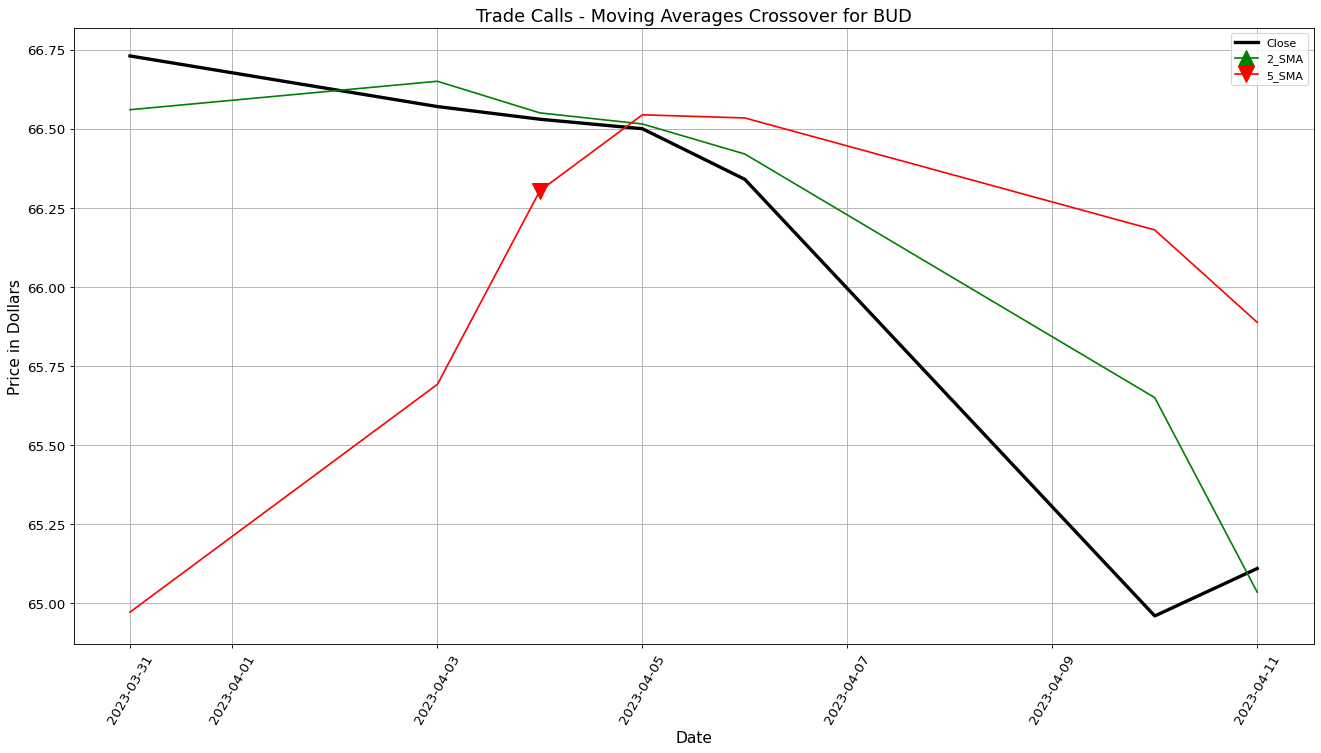

VADER sentiment score to generate trading signals
Trade Call for 2023-04-03 is Sell.
Trade Call for 2023-04-07 is Buy.
Using VADER sentiment


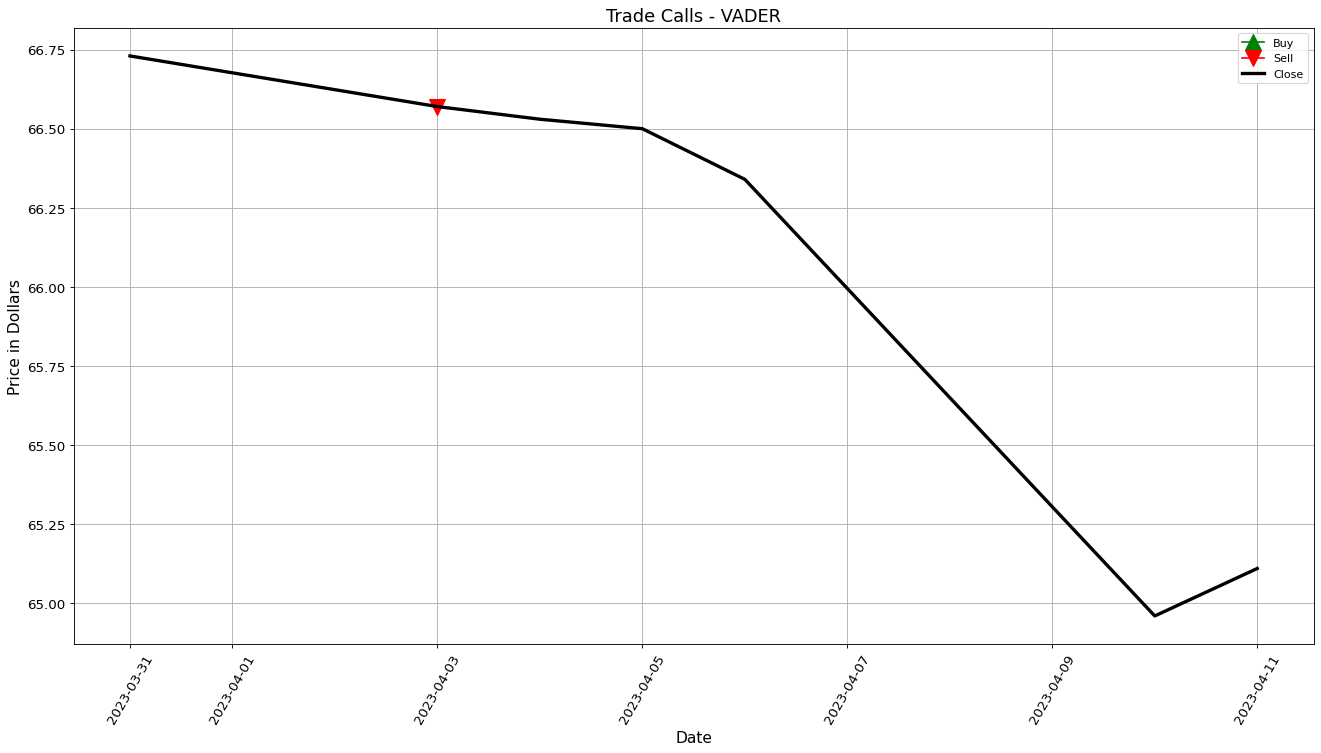

Using VADER sentiment and the simple moving average strategy


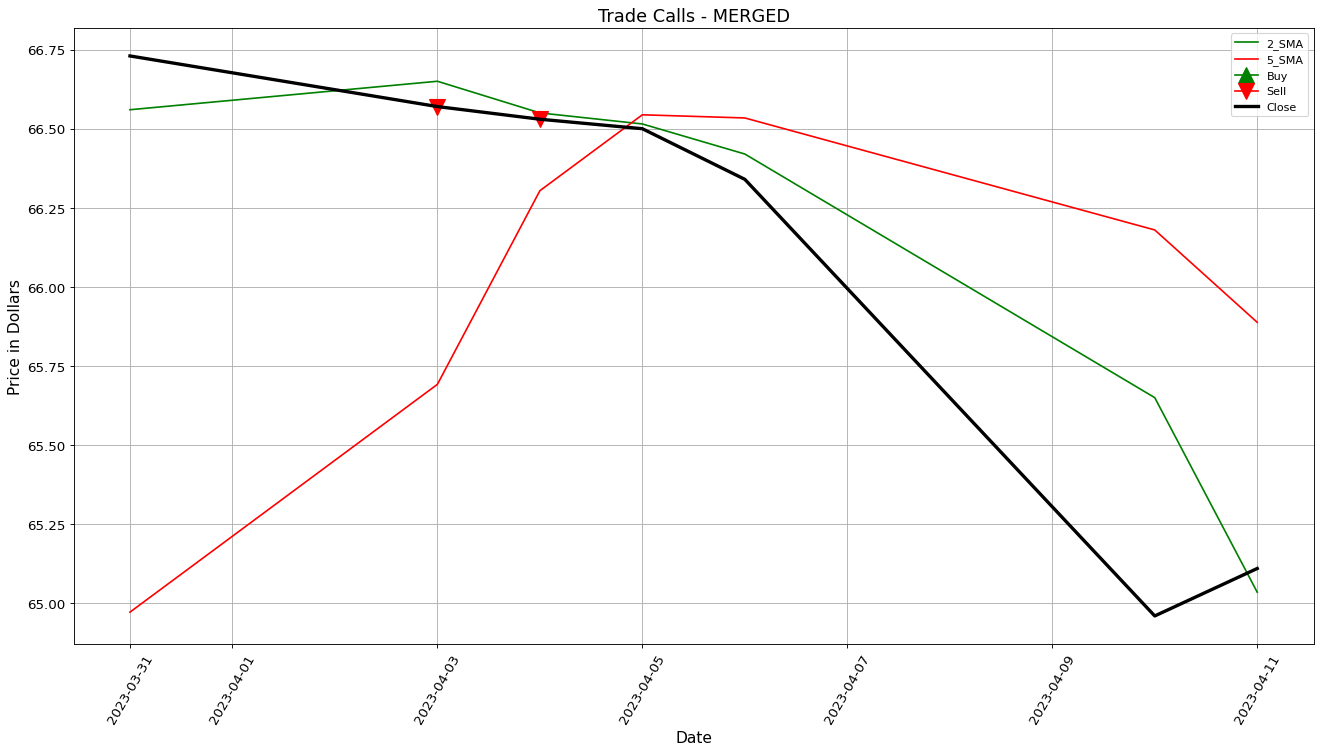

In [7]:
#first drop 
feeds = pd.read_csv("BUD_0331_0412.csv")
feeds['created_at'] = pd.to_datetime(feeds['created_at'])-  pd.to_timedelta(4, unit='h')
feeds = feeds.sort_values(by=['created_at']).reset_index(drop = True)
feeds = feeds[(feeds['text'].notna())& (feeds['platform']=='twitter')].reset_index(drop = True)
n = len(feeds['text'])

compound = []
date = []
for i in range(n):
#     print(i, sentiment_analyzer_scores(feeds['text'][i])['compound'])
    compound.append(sentiment_analyzer_scores(feeds['text'][i])['compound'])
    date.append(feeds['created_at'][i].date())
    
feeds['Sentiment Score'] = compound
feeds['date'] = date
showdrop(data, '2023-04-12',feeds)

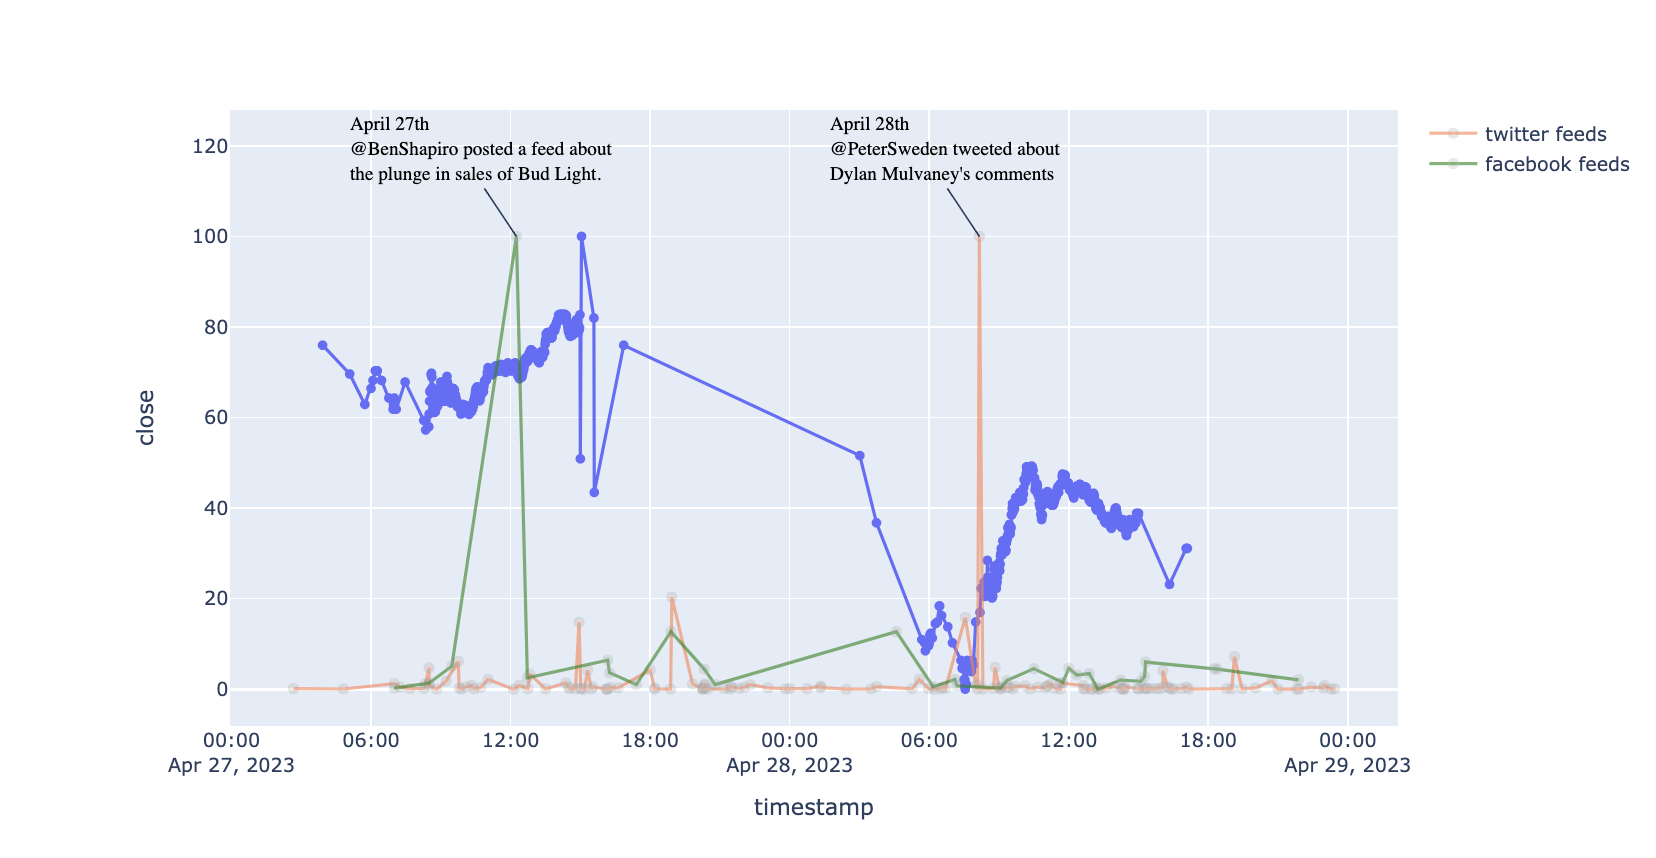

Simple Moving Crossover Strategy to generate trade signals
Trade Call for 2023-04-04 is Sell.
Trade Call for 2023-04-14 is Buy.
Trade Call for 2023-04-27 is Sell.


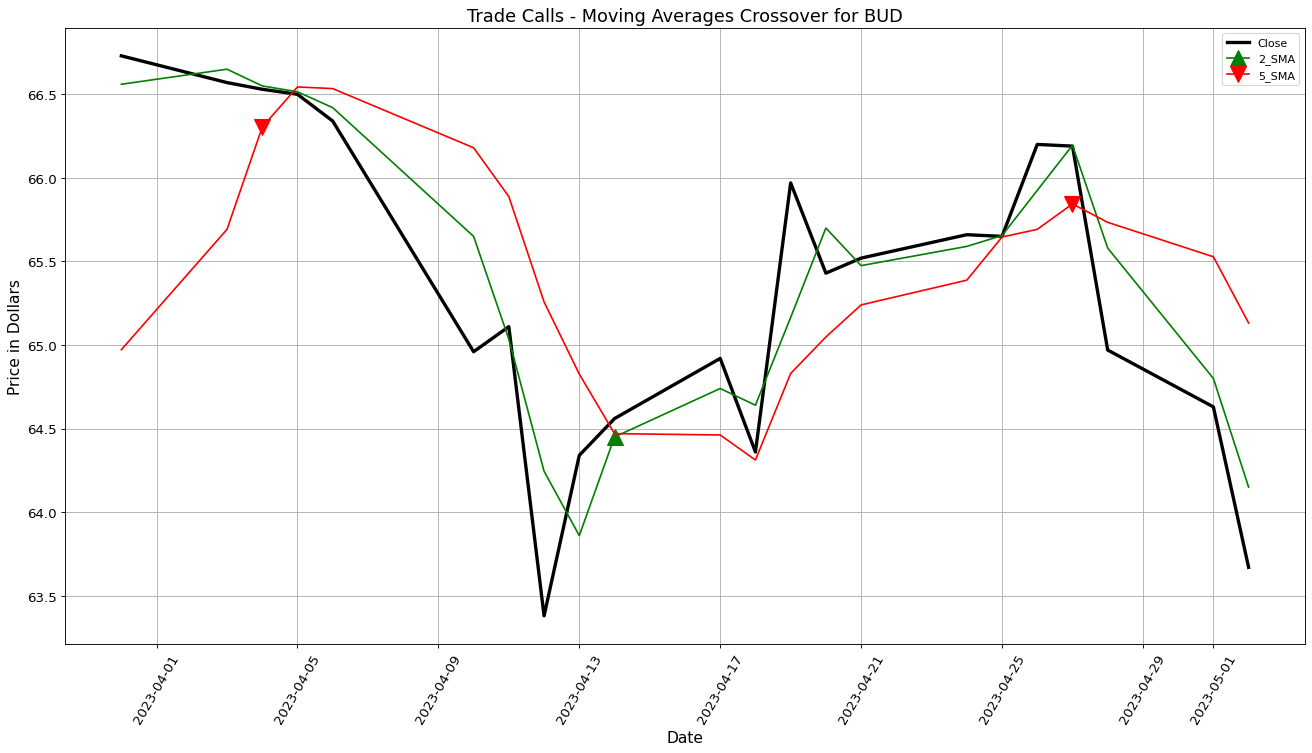

VADER sentiment score to generate trading signals
Trade Call for 2023-04-26 is Sell.
Trade Call for 2023-04-28 is Sell.
Trade Call for 2023-04-30 is Sell.
Using VADER sentiment


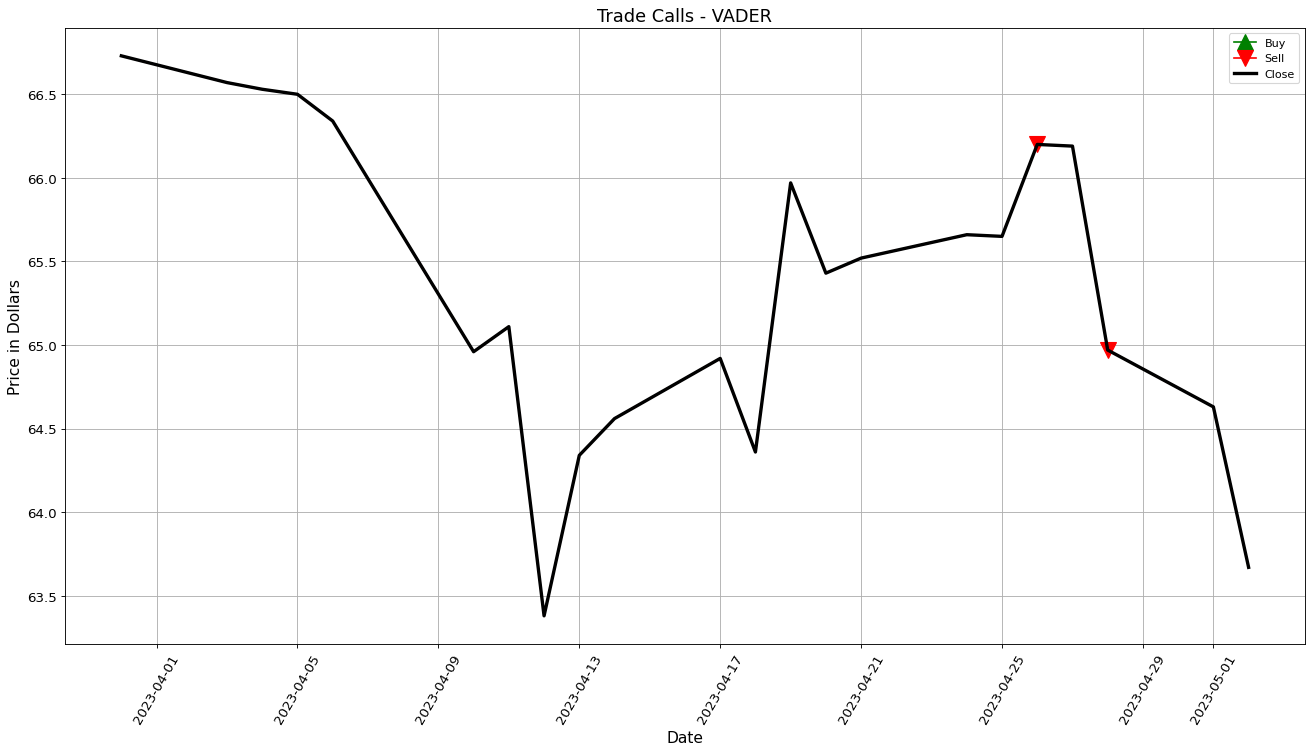

Using VADER sentiment and the simple moving average strategy


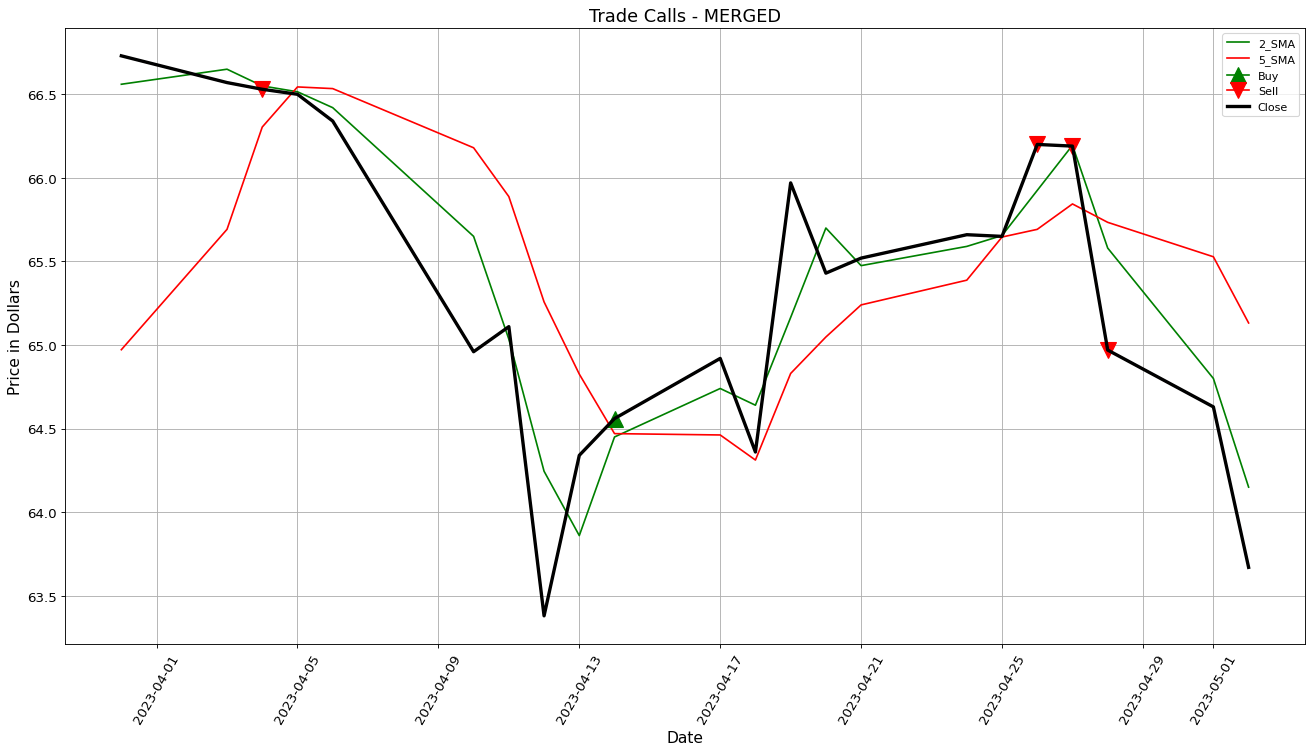

In [8]:
#second drop 
feeds = pd.read_csv("BUD_0427_0503.csv")
feeds['created_at'] = pd.to_datetime(feeds['created_at'])-  pd.to_timedelta(4, unit='h')
feeds = feeds.sort_values(by=['created_at']).reset_index(drop = True)
feeds = feeds[(feeds['text'].notna())& (feeds['platform']=='twitter')].reset_index(drop = True)
n = len(feeds['text'])

compound = []
date = []
for i in range(n):
#     print(i, sentiment_analyzer_scores(feeds['text'][i])['compound'])
    compound.append(sentiment_analyzer_scores(feeds['text'][i])['compound'])
    date.append(feeds['created_at'][i].date())
    
feeds['Sentiment Score'] = compound
feeds['date'] = date

feeds['Sentiment Score'] = compound
feeds['date'] = date
showdrop(data, '2023-05-03',feeds)

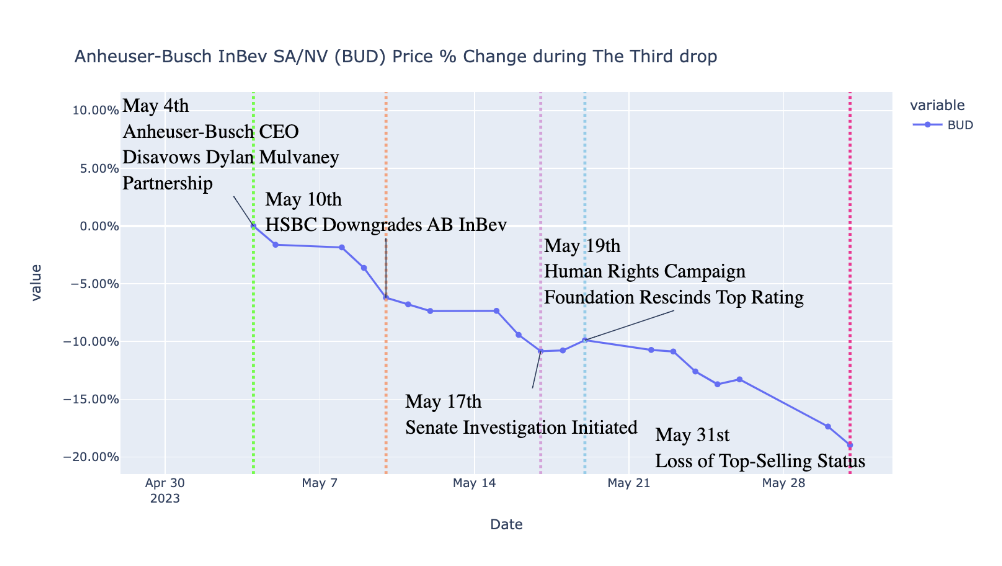

Simple Moving Crossover Strategy to generate trade signals
Trade Call for 2023-04-04 is Sell.
Trade Call for 2023-04-14 is Buy.
Trade Call for 2023-04-27 is Sell.
Trade Call for 2023-05-03 is Buy.
Trade Call for 2023-05-08 is Sell.
Trade Call for 2023-05-19 is Buy.
Trade Call for 2023-05-22 is Sell.


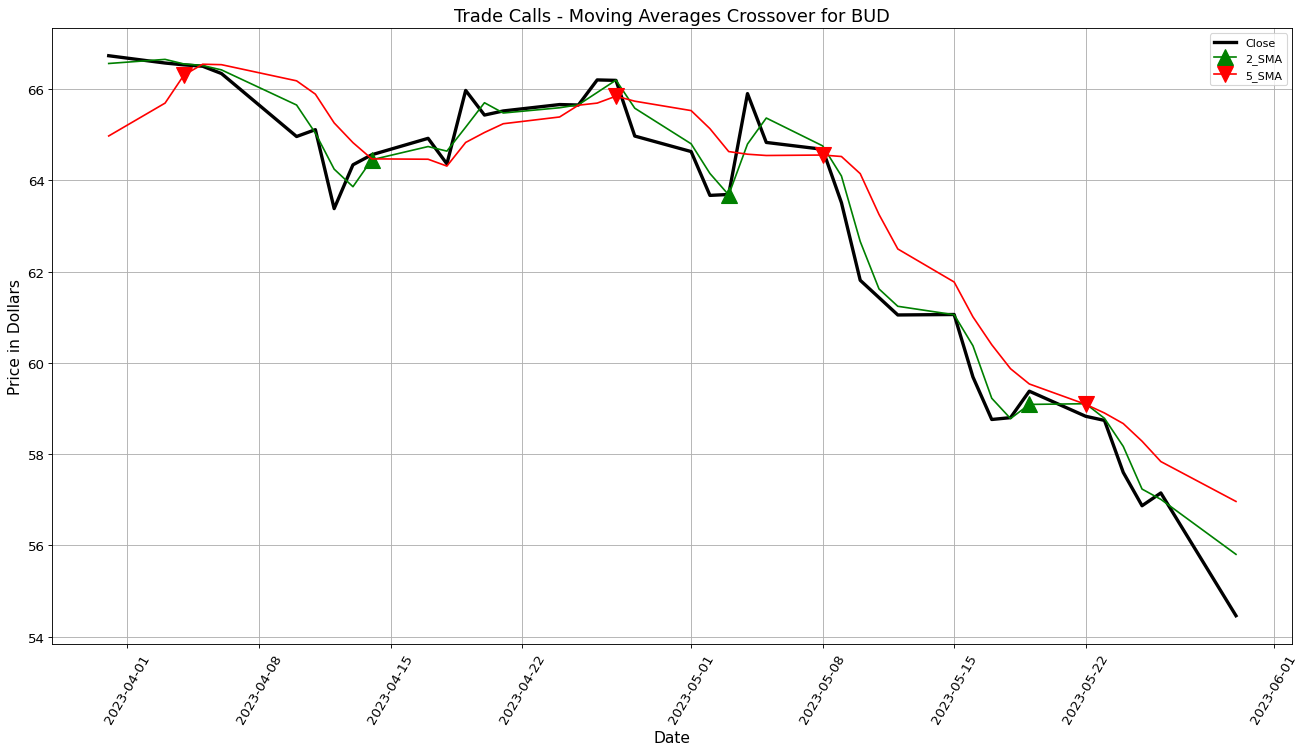

VADER sentiment score to generate trading signals
Trade Call for 2023-05-06 is Sell.
Trade Call for 2023-05-07 is Sell.
Trade Call for 2023-05-08 is Sell.
Trade Call for 2023-05-09 is Sell.
Trade Call for 2023-05-10 is Sell.
Trade Call for 2023-05-11 is Sell.
Trade Call for 2023-05-12 is Sell.
Trade Call for 2023-05-15 is Sell.
Trade Call for 2023-05-18 is Sell.
Trade Call for 2023-05-21 is Sell.
Trade Call for 2023-05-26 is Buy.
Trade Call for 2023-05-27 is Sell.
Trade Call for 2023-05-31 is Sell.
Using VADER sentiment


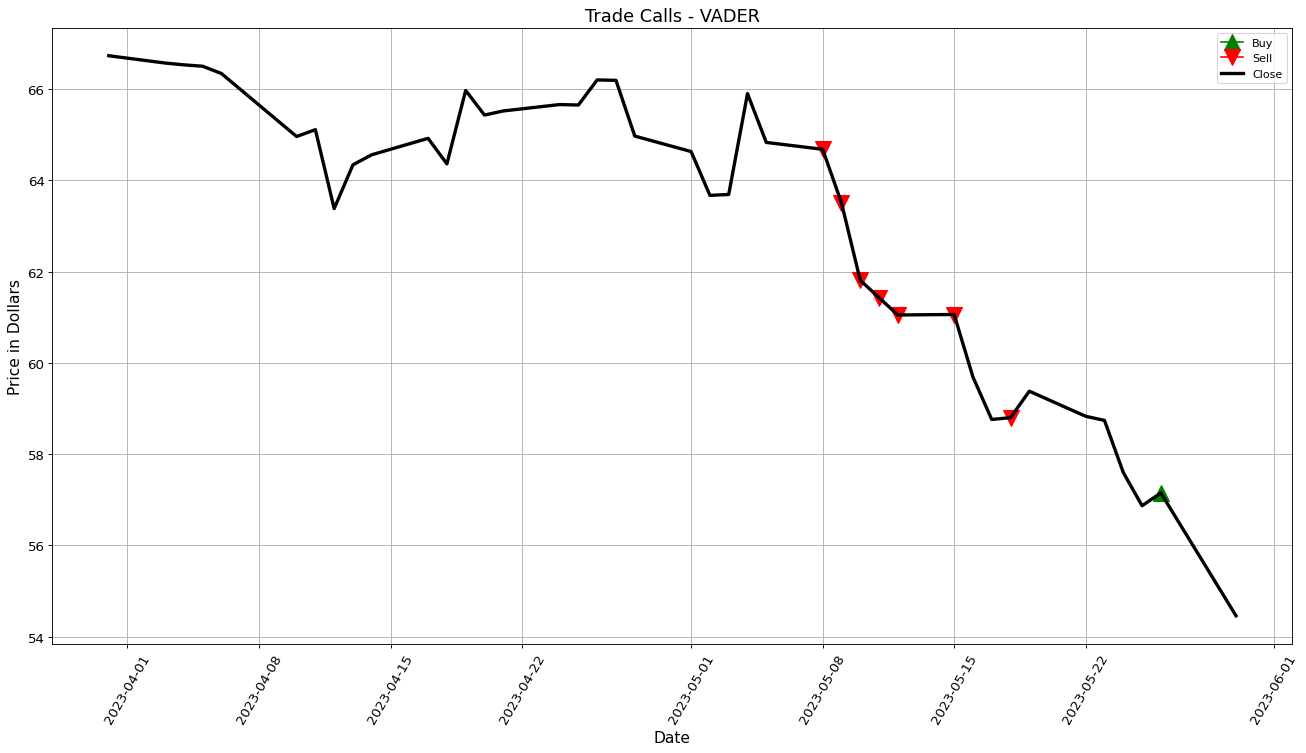

Using VADER sentiment and the simple moving average strategy


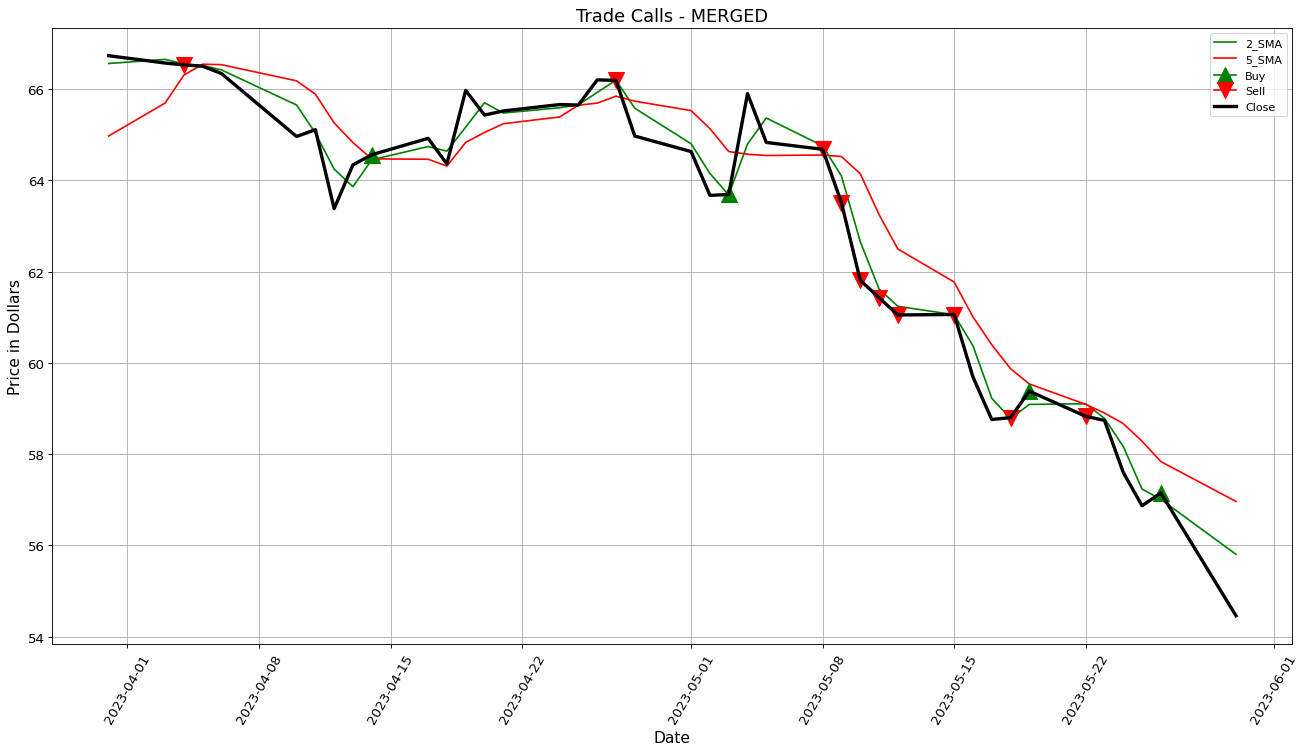

In [9]:
#third drop 
feeds = pd.read_csv("BUD_0501_0531.csv")
feeds['created_at'] = pd.to_datetime(feeds['created_at'])-  pd.to_timedelta(4, unit='h')
feeds = feeds.sort_values(by=['created_at']).reset_index(drop = True)
feeds = feeds[(feeds['text'].notna())& (feeds['platform']=='twitter')].reset_index(drop = True)
n = len(feeds['text'])

compound = []
date = []
for i in range(n):
#     print(i, sentiment_analyzer_scores(feeds['text'][i])['compound'])
    compound.append(sentiment_analyzer_scores(feeds['text'][i])['compound'])
    date.append(feeds['created_at'][i].date())
    
feeds['Sentiment Score'] = compound
feeds['date'] = date

feeds['Sentiment Score'] = compound
feeds['date'] = date
showdrop(data, '2023-05-31',feeds)

In [10]:
#all together

df1 = pd.read_csv("BUD_0331_0412.csv")
df2 = pd.read_csv("BUD_0427_0503.csv")
df3 = pd.read_csv("BUD_0501_0531.csv")
pdList = [df1, df2, df3]  # List of your dataframes
df = pd.concat(pdList)
df['created_at'] = pd.to_datetime(df['created_at'])-  pd.to_timedelta(4, unit='h')
df = df.sort_values(by=['created_at']).reset_index(drop = True)


In [11]:
df['platform'].unique()

array(['instagram', 'twitter', 'youtube', 'facebook', 'reddit'],
      dtype=object)

Simple Moving Crossover Strategy to generate trade signals
Trade Call for 2023-04-04 is Sell.
Trade Call for 2023-04-14 is Buy.
Trade Call for 2023-04-27 is Sell.
Trade Call for 2023-05-03 is Buy.
Trade Call for 2023-05-08 is Sell.
Trade Call for 2023-05-19 is Buy.
Trade Call for 2023-05-22 is Sell.


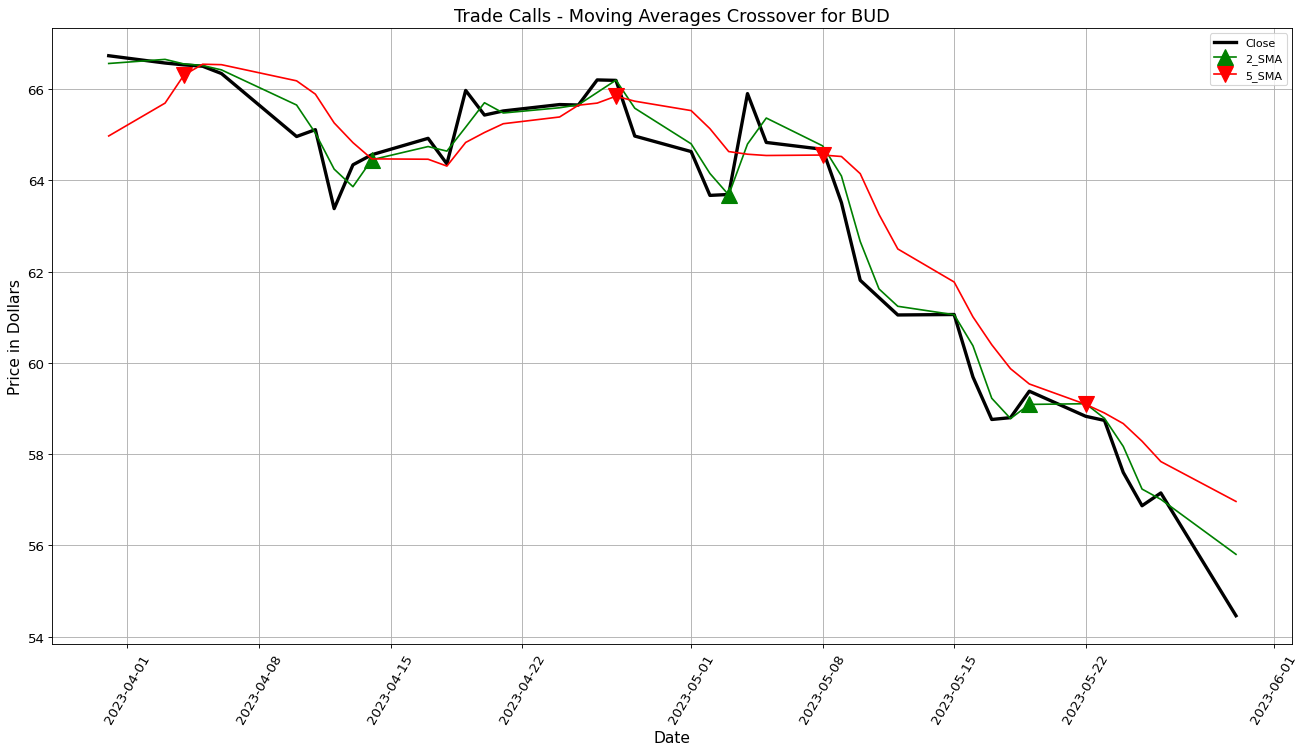

VADER sentiment score to generate trading signals
Trade Call for 2023-04-02 is Buy.
Trade Call for 2023-04-26 is Buy.
Trade Call for 2023-05-03 is Sell.
Trade Call for 2023-05-04 is Buy.
Trade Call for 2023-05-06 is Sell.
Trade Call for 2023-05-08 is Sell.
Trade Call for 2023-05-09 is Sell.
Trade Call for 2023-05-12 is Sell.
Trade Call for 2023-05-13 is Sell.
Trade Call for 2023-05-14 is Buy.
Trade Call for 2023-05-15 is Buy.
Trade Call for 2023-05-19 is Sell.
Trade Call for 2023-05-22 is Sell.
Trade Call for 2023-05-23 is Buy.
Trade Call for 2023-05-24 is Sell.
Trade Call for 2023-05-27 is Sell.
Trade Call for 2023-05-28 is Sell.
Trade Call for 2023-05-29 is Sell.
Using VADER sentiment


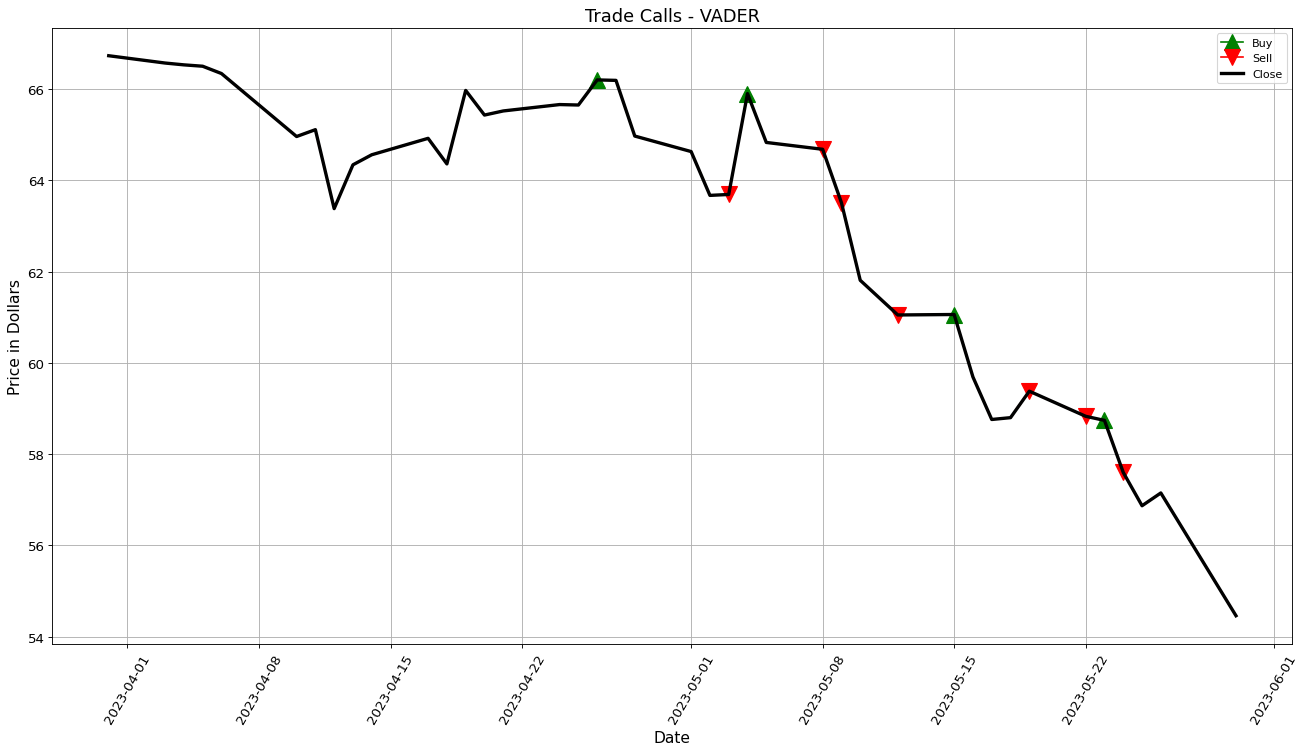

Using VADER sentiment and the simple moving average strategy


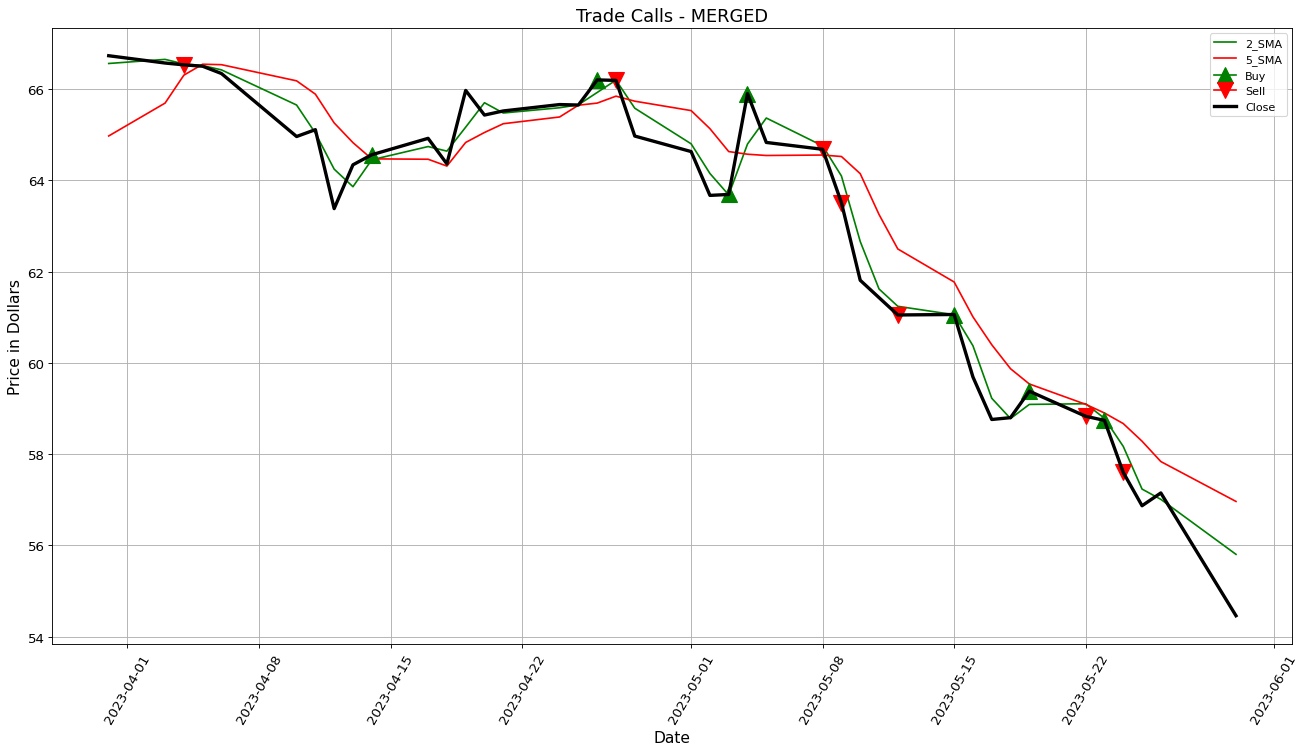

In [12]:
#facebook
new_df = df[(df['text'].notna())&(df['platform']=='facebook')].reset_index(drop = True)
n = len(new_df['text'])

compound = []
date = []
for i in range(n):
#     print(i, sentiment_analyzer_scores(feeds['text'][i])['compound'])
    compound.append(sentiment_analyzer_scores(new_df['text'][i])['compound'])
    date.append(new_df['created_at'][i].date())
    
new_df['Sentiment Score'] = compound
new_df['date'] = date

new_df['Sentiment Score'] = compound
new_df['date'] = date
showdrop(data, '2023-05-31',new_df)

Simple Moving Crossover Strategy to generate trade signals
Trade Call for 2023-04-04 is Sell.
Trade Call for 2023-04-14 is Buy.
Trade Call for 2023-04-27 is Sell.
Trade Call for 2023-05-03 is Buy.
Trade Call for 2023-05-08 is Sell.
Trade Call for 2023-05-19 is Buy.
Trade Call for 2023-05-22 is Sell.


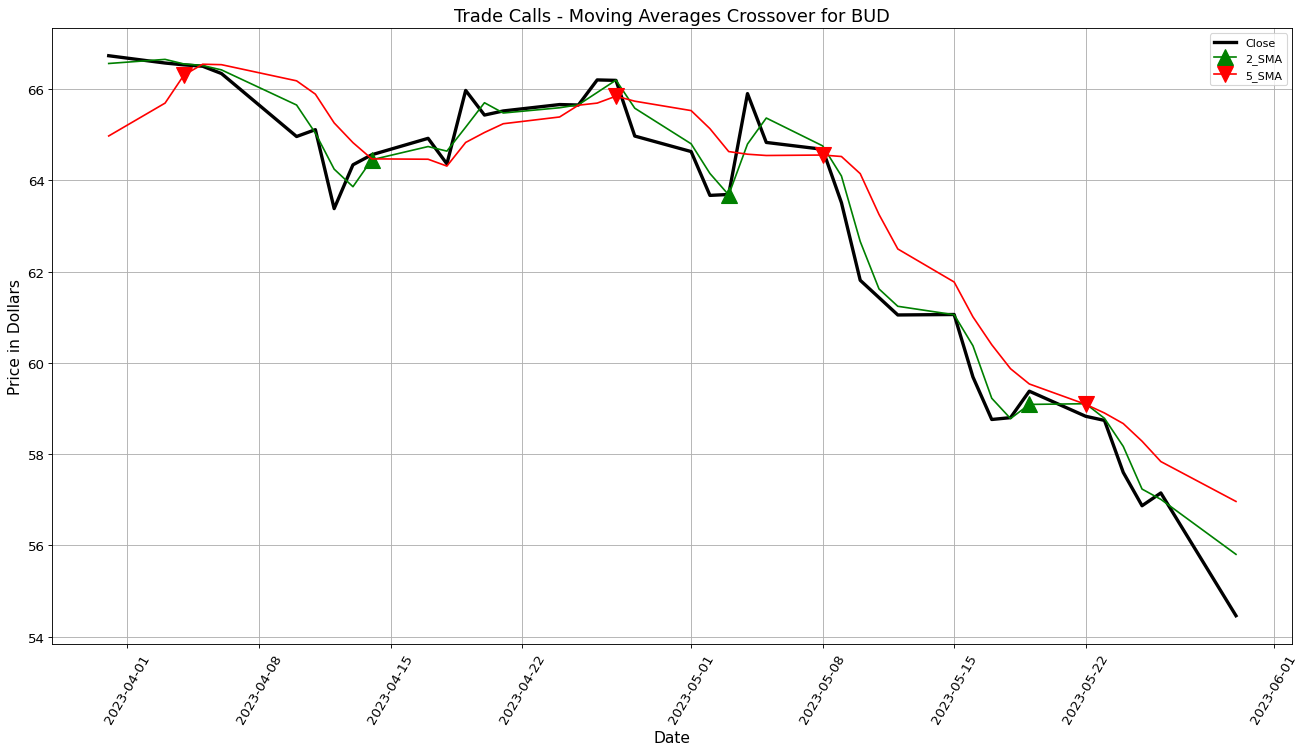

VADER sentiment score to generate trading signals
Trade Call for 2023-04-03 is Sell.
Trade Call for 2023-04-07 is Buy.
Trade Call for 2023-04-26 is Sell.
Trade Call for 2023-04-28 is Sell.
Trade Call for 2023-04-30 is Sell.
Trade Call for 2023-05-06 is Sell.
Trade Call for 2023-05-07 is Sell.
Trade Call for 2023-05-08 is Sell.
Trade Call for 2023-05-09 is Sell.
Trade Call for 2023-05-10 is Sell.
Trade Call for 2023-05-11 is Sell.
Trade Call for 2023-05-12 is Sell.
Trade Call for 2023-05-15 is Sell.
Trade Call for 2023-05-18 is Sell.
Trade Call for 2023-05-21 is Sell.
Trade Call for 2023-05-26 is Buy.
Trade Call for 2023-05-27 is Sell.
Trade Call for 2023-05-31 is Sell.
Using VADER sentiment


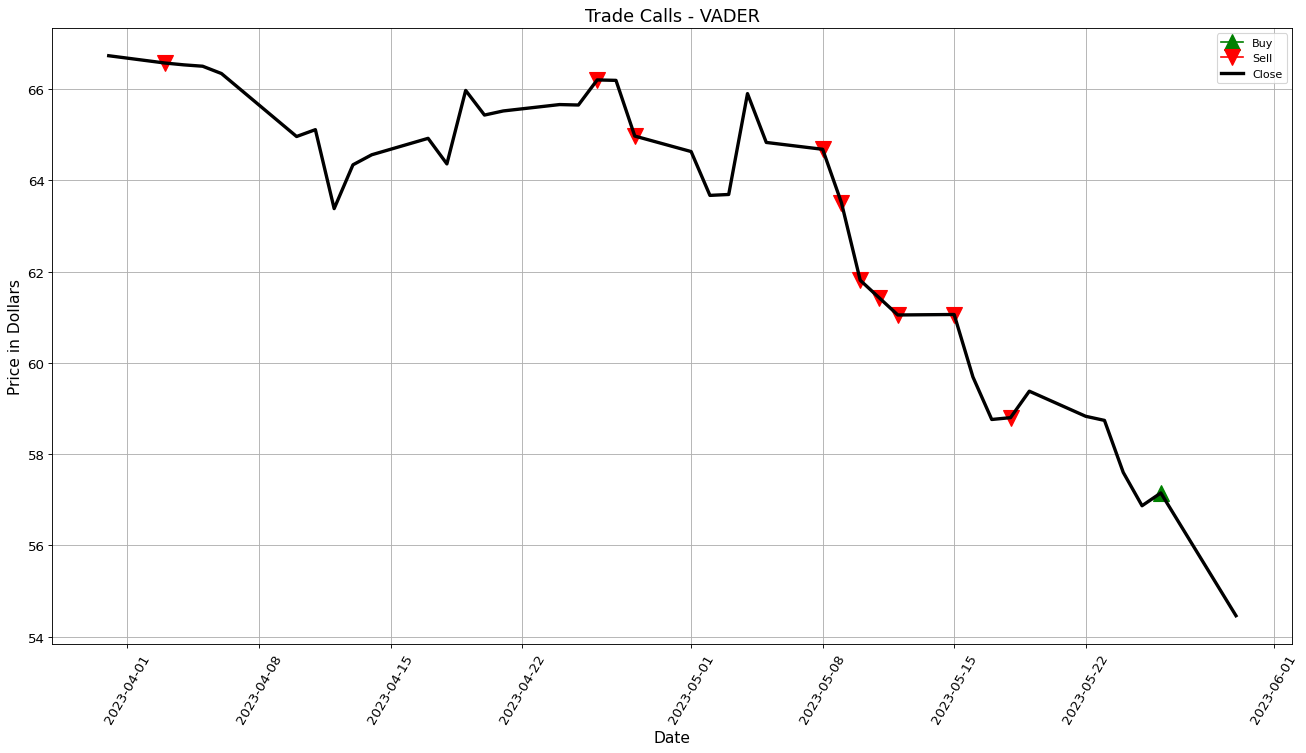

Using VADER sentiment and the simple moving average strategy


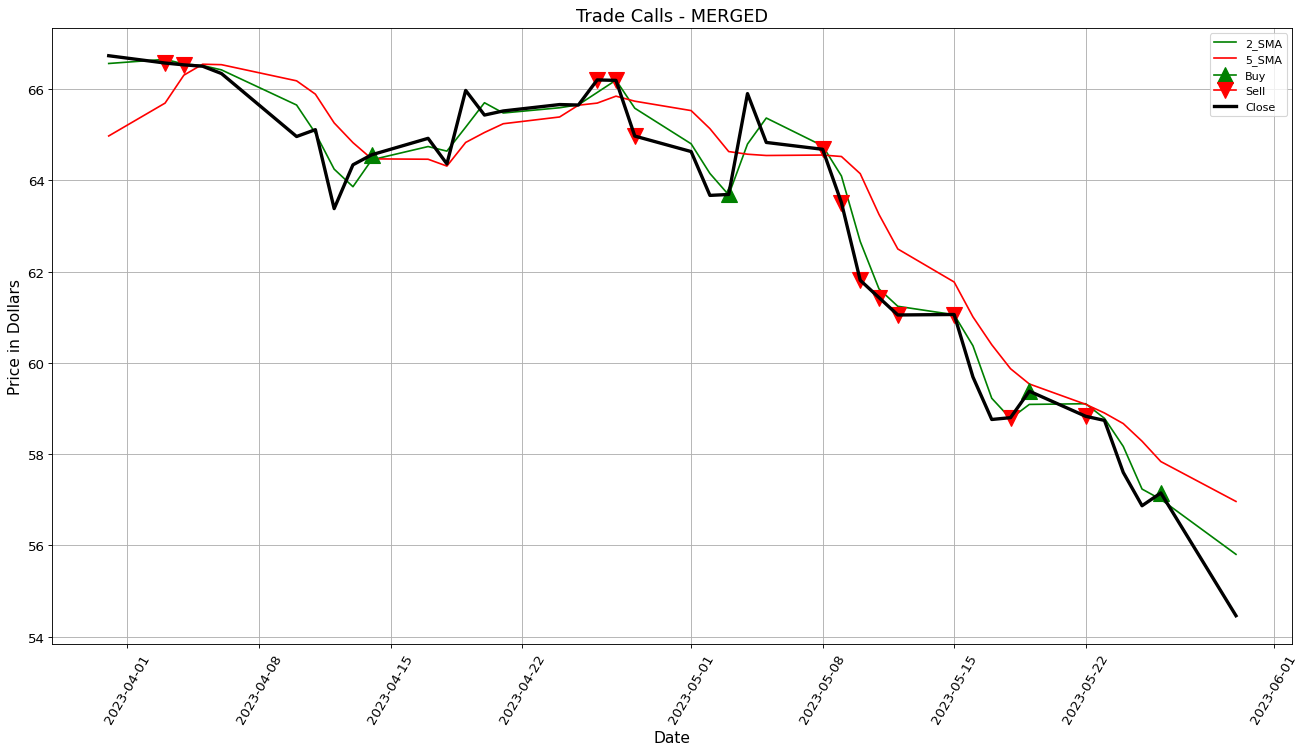

In [13]:
#twitter

new_df = df[(df['text'].notna())&(df['platform']=='twitter')].reset_index(drop = True)
n = len(new_df['text'])

compound = []
date = []
for i in range(n):
#     print(i, sentiment_analyzer_scores(feeds['text'][i])['compound'])
    compound.append(sentiment_analyzer_scores(new_df['text'][i])['compound'])
    date.append(new_df['created_at'][i].date())
    
new_df['Sentiment Score'] = compound
new_df['date'] = date

new_df['Sentiment Score'] = compound
new_df['date'] = date
showdrop(data, '2023-05-31',new_df)

Simple Moving Crossover Strategy to generate trade signals
Trade Call for 2023-04-04 is Sell.
Trade Call for 2023-04-14 is Buy.
Trade Call for 2023-04-27 is Sell.
Trade Call for 2023-05-03 is Buy.
Trade Call for 2023-05-08 is Sell.
Trade Call for 2023-05-19 is Buy.
Trade Call for 2023-05-22 is Sell.


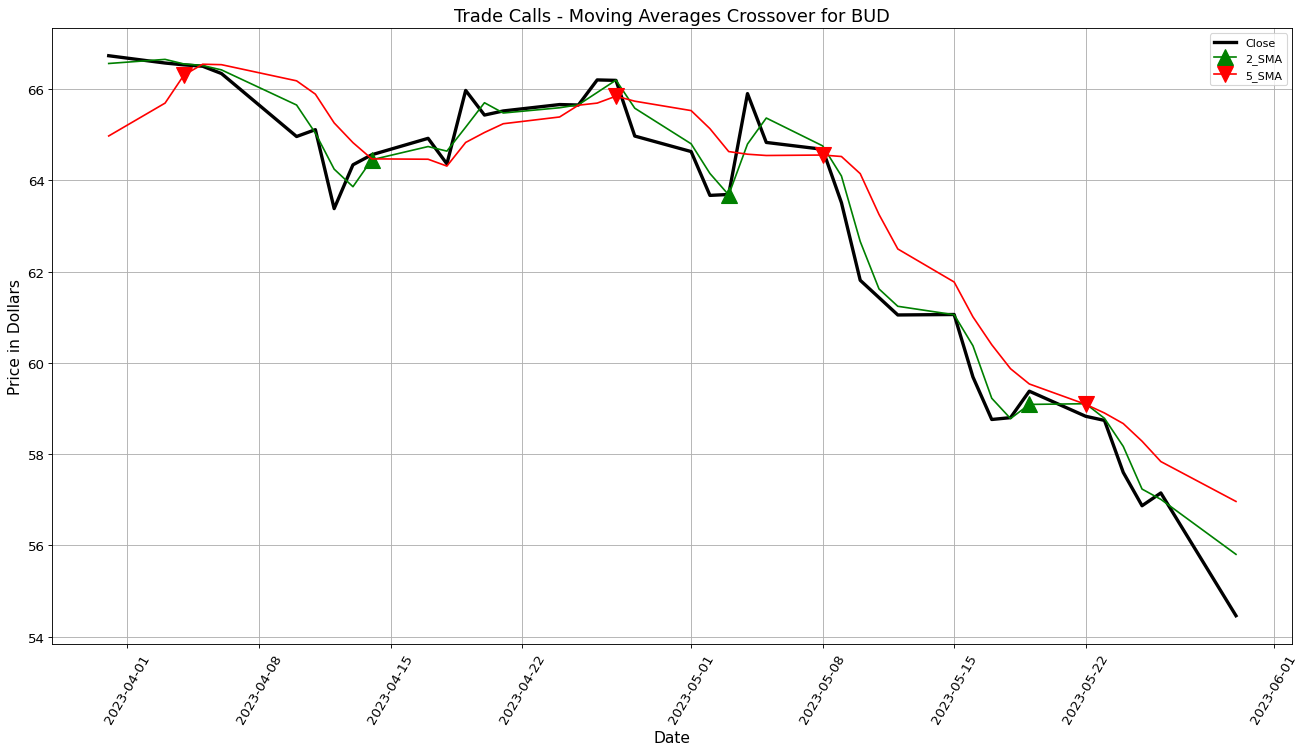

VADER sentiment score to generate trading signals
Trade Call for 2023-04-04 is Sell.
Trade Call for 2023-04-05 is Sell.
Trade Call for 2023-04-10 is Sell.
Trade Call for 2023-04-11 is Sell.
Trade Call for 2023-04-28 is Sell.
Trade Call for 2023-04-29 is Sell.
Trade Call for 2023-05-02 is Sell.
Trade Call for 2023-05-04 is Buy.
Trade Call for 2023-05-07 is Sell.
Trade Call for 2023-05-08 is Sell.
Trade Call for 2023-05-09 is Sell.
Trade Call for 2023-05-10 is Sell.
Trade Call for 2023-05-12 is Sell.
Trade Call for 2023-05-16 is Sell.
Trade Call for 2023-05-17 is Sell.
Trade Call for 2023-05-20 is Buy.
Trade Call for 2023-05-22 is Sell.
Using VADER sentiment


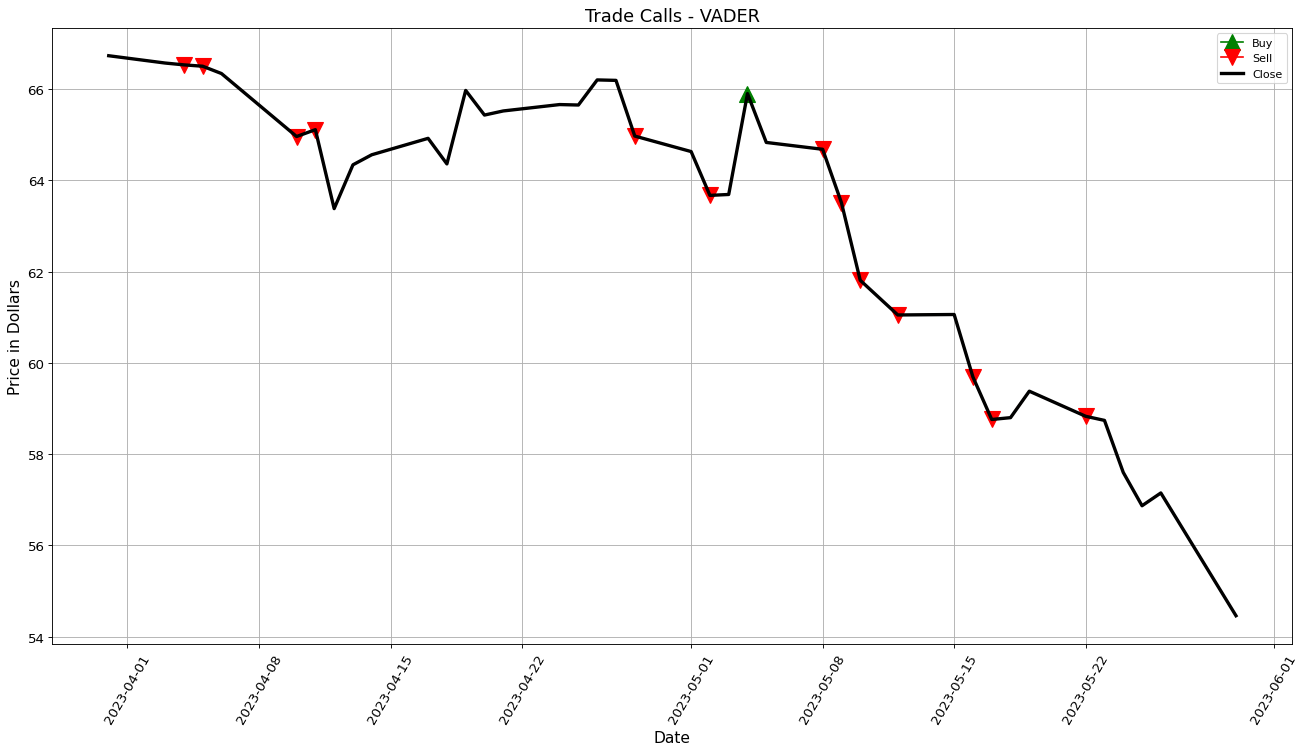

Using VADER sentiment and the simple moving average strategy


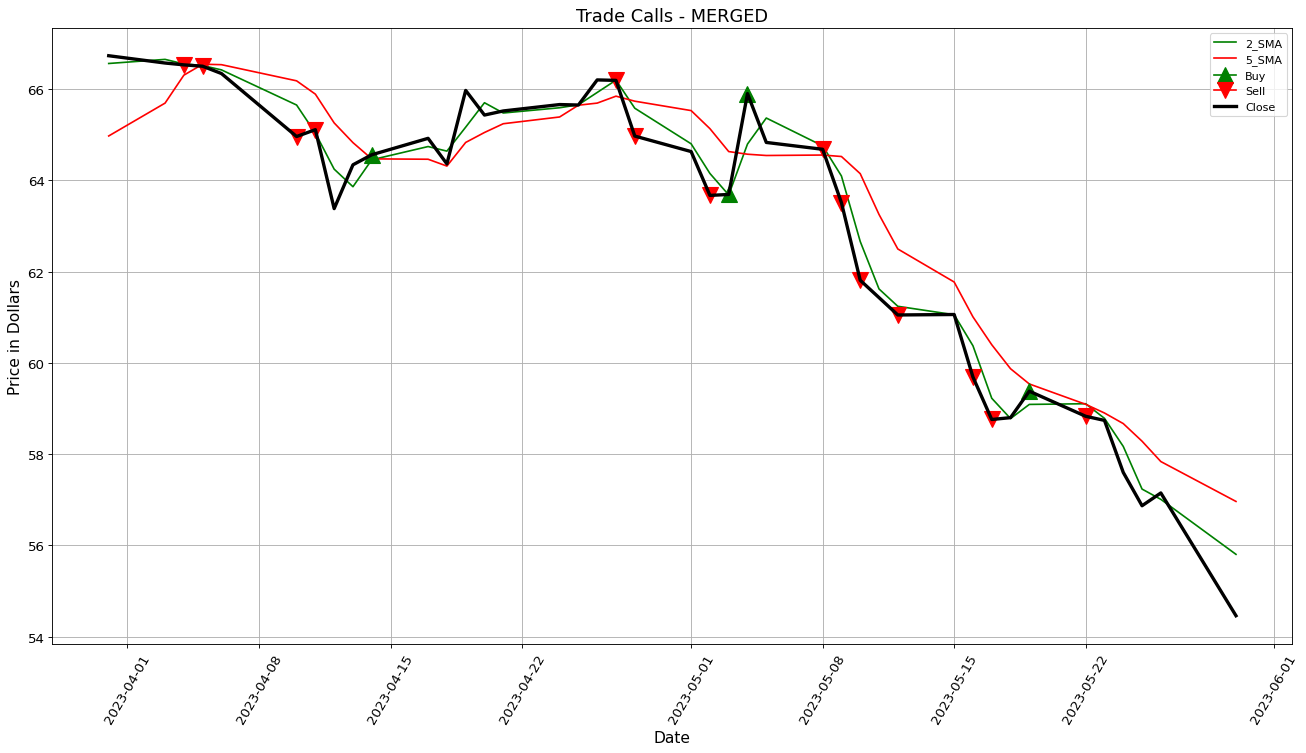

In [14]:
#reddit

new_df = df[(df['text'].notna())&(df['platform']=='reddit')].reset_index(drop = True)
n = len(new_df['text'])

compound = []
date = []
for i in range(n):
#     print(i, sentiment_analyzer_scores(feeds['text'][i])['compound'])
    compound.append(sentiment_analyzer_scores(new_df['text'][i])['compound'])
    date.append(new_df['created_at'][i].date())
    
new_df['Sentiment Score'] = compound
new_df['date'] = date

new_df['Sentiment Score'] = compound
new_df['date'] = date
showdrop(data, '2023-05-31',new_df)

Simple Moving Crossover Strategy to generate trade signals
Trade Call for 2023-04-04 is Sell.
Trade Call for 2023-04-14 is Buy.
Trade Call for 2023-04-27 is Sell.
Trade Call for 2023-05-03 is Buy.
Trade Call for 2023-05-08 is Sell.
Trade Call for 2023-05-19 is Buy.
Trade Call for 2023-05-22 is Sell.


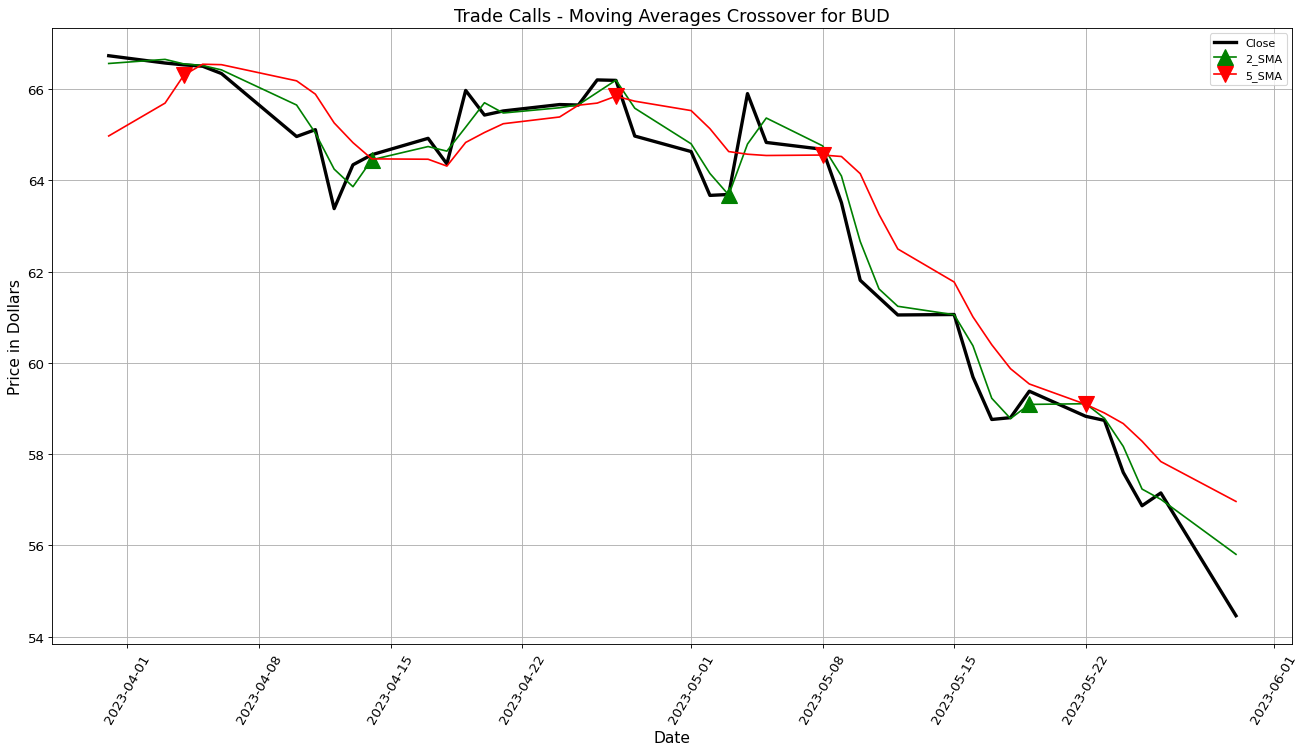

VADER sentiment score to generate trading signals
Trade Call for 2023-03-31 is Buy.
Trade Call for 2023-04-02 is Buy.
Trade Call for 2023-05-14 is Buy.
Trade Call for 2023-05-15 is Buy.
Trade Call for 2023-05-26 is Buy.
Using VADER sentiment


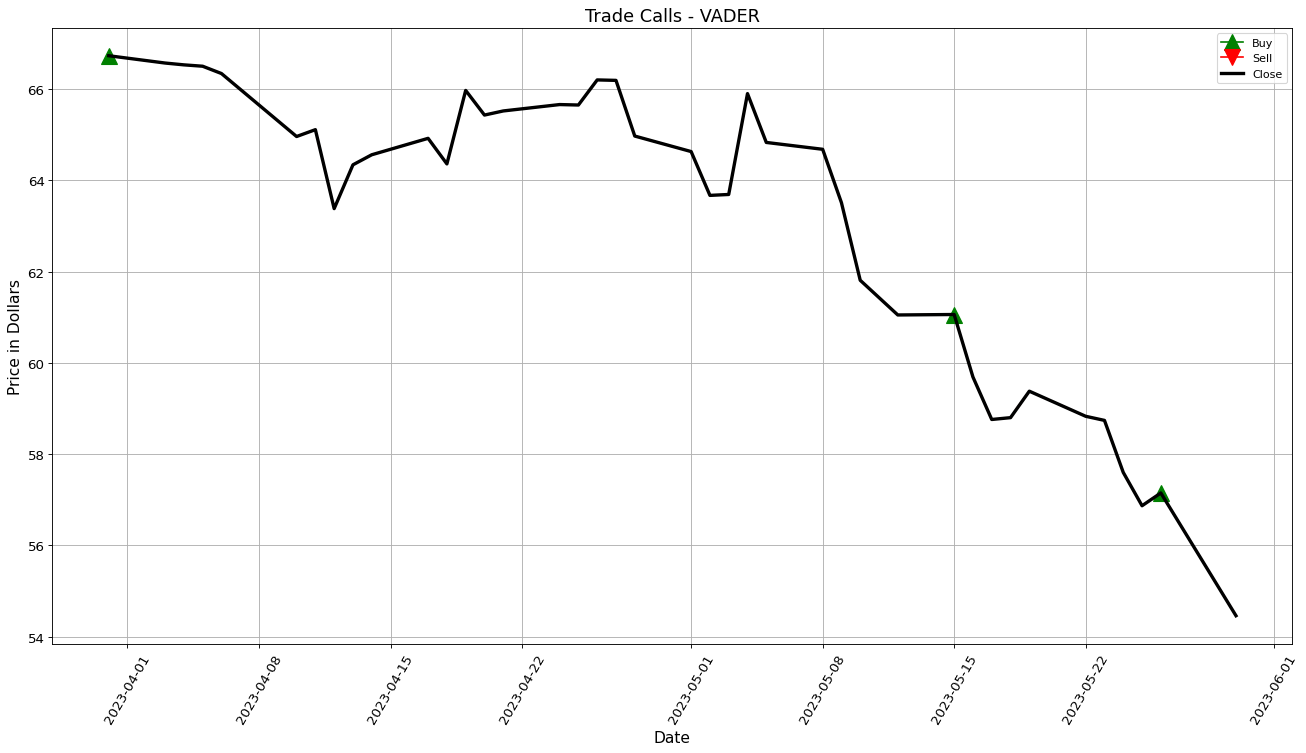

Using VADER sentiment and the simple moving average strategy


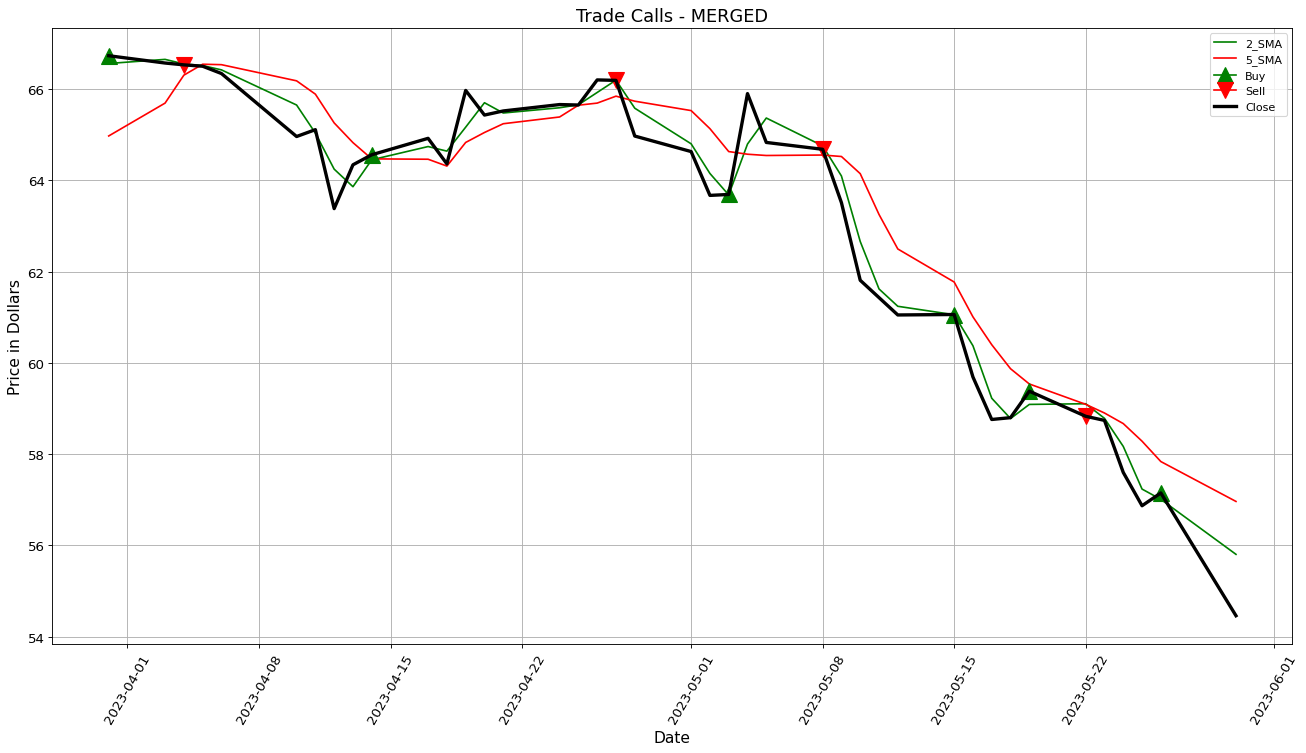

In [15]:
#all

new_df = df[(df['text'].notna())].reset_index(drop = True)
n = len(new_df['text'])

compound = []
date = []
for i in range(n):
#     print(i, sentiment_analyzer_scores(feeds['text'][i])['compound'])
    compound.append(sentiment_analyzer_scores(new_df['text'][i])['compound'])
    date.append(new_df['created_at'][i].date())
    
new_df['Sentiment Score'] = compound
new_df['date'] = date

new_df['Sentiment Score'] = compound
new_df['date'] = date
showdrop(data, '2023-05-31',new_df)

Simple Moving Crossover Strategy to generate trade signals
Trade Call for 2023-04-04 is Sell.
Trade Call for 2023-04-14 is Buy.
Trade Call for 2023-04-27 is Sell.
Trade Call for 2023-05-03 is Buy.
Trade Call for 2023-05-08 is Sell.
Trade Call for 2023-05-19 is Buy.
Trade Call for 2023-05-22 is Sell.


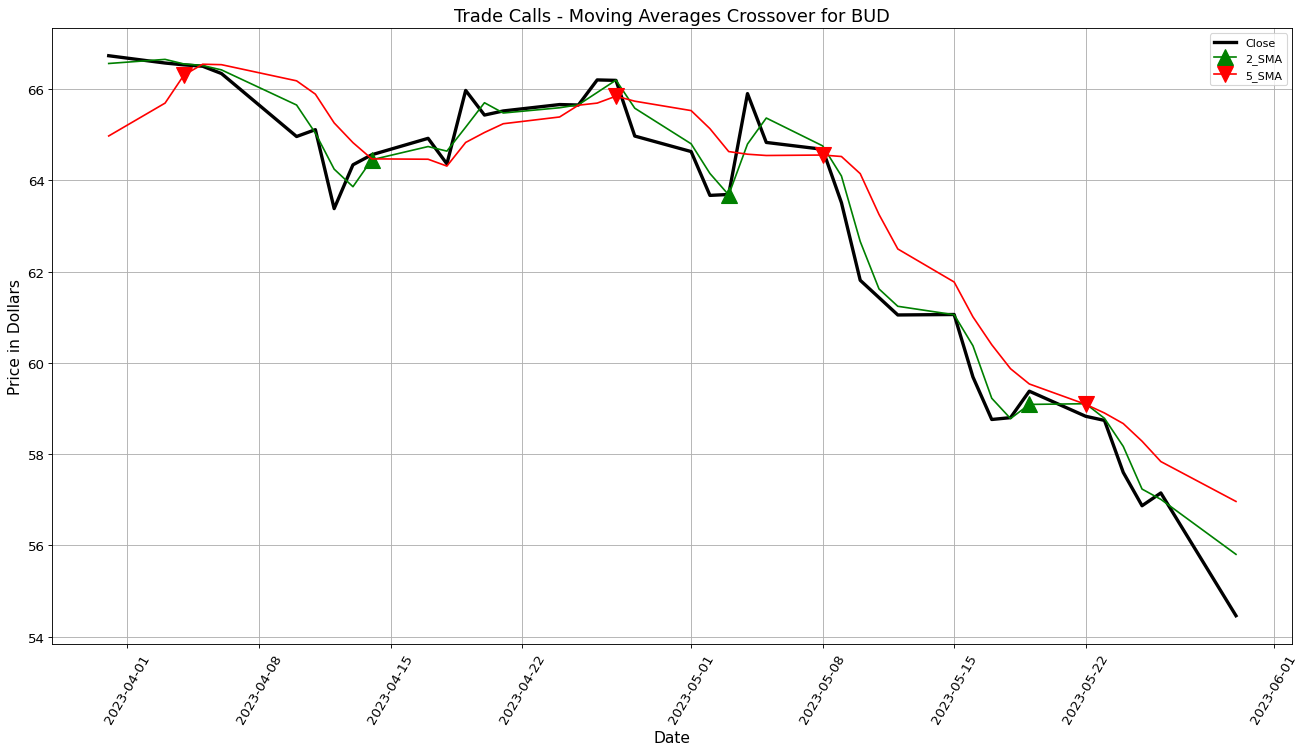

VADER sentiment score to generate trading signals
Trade Call for 2023-04-03 is Sell.
Trade Call for 2023-04-07 is Buy.
Trade Call for 2023-04-26 is Sell.
Trade Call for 2023-04-28 is Sell.
Trade Call for 2023-04-30 is Sell.
Trade Call for 2023-05-06 is Sell.
Trade Call for 2023-05-07 is Sell.
Trade Call for 2023-05-08 is Sell.
Trade Call for 2023-05-09 is Sell.
Trade Call for 2023-05-10 is Sell.
Trade Call for 2023-05-11 is Sell.
Trade Call for 2023-05-12 is Sell.
Trade Call for 2023-05-15 is Sell.
Trade Call for 2023-05-18 is Sell.
Trade Call for 2023-05-21 is Sell.
Trade Call for 2023-05-26 is Buy.
Trade Call for 2023-05-27 is Sell.
Trade Call for 2023-05-31 is Sell.
Using VADER sentiment


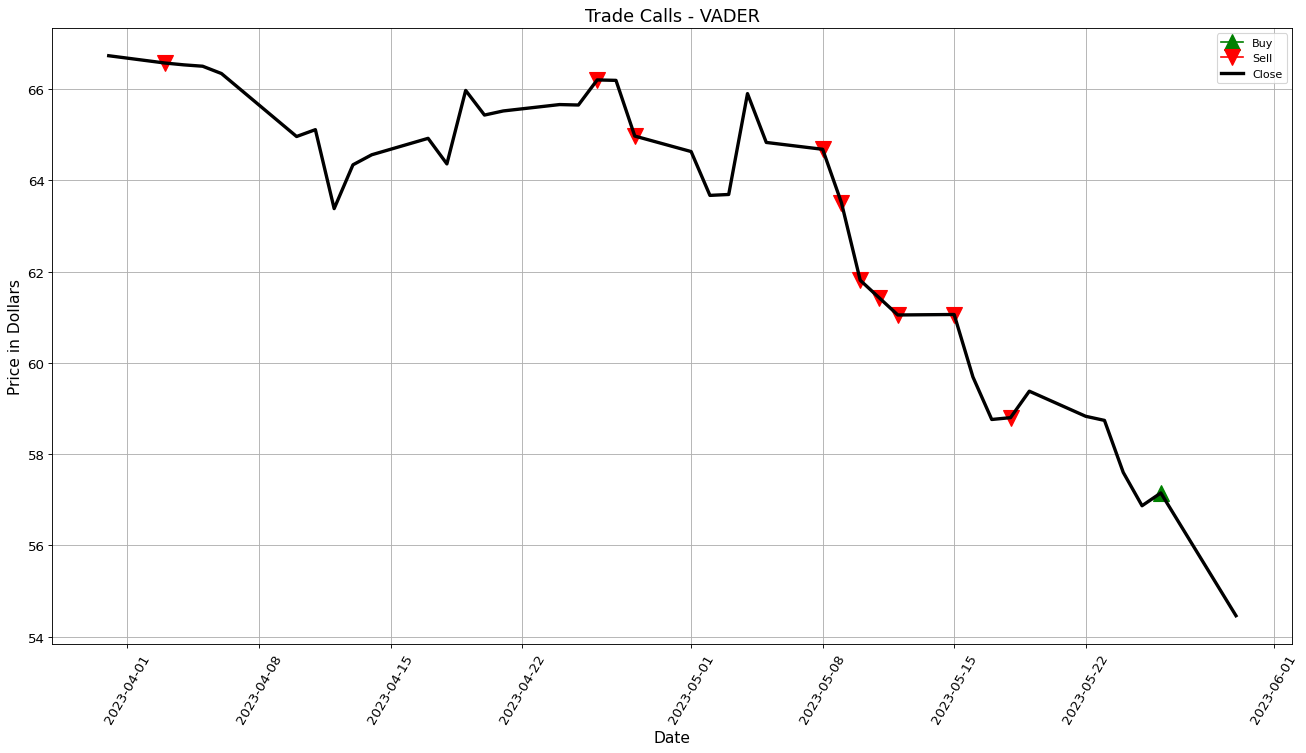

Using VADER sentiment and the simple moving average strategy


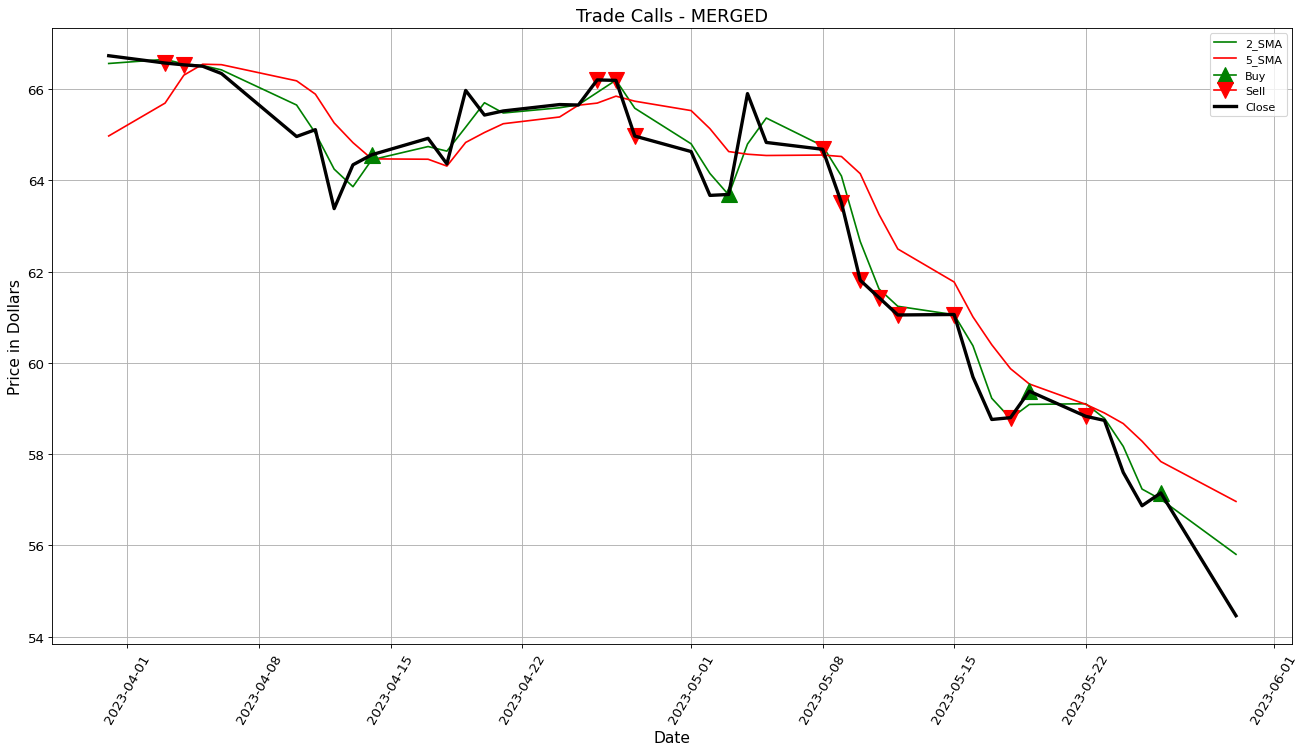

In [18]:
#only 

new_df = df[(df['text'].notna())&((df['platform']=='twitter')|(df['platform']=='reddit'))].reset_index(drop = True)
n = len(new_df['text'])

compound = []
date = []
for i in range(n):
#     print(i, sentiment_analyzer_scores(feeds['text'][i])['compound'])
    compound.append(sentiment_analyzer_scores(new_df['text'][i])['compound'])
    date.append(new_df['created_at'][i].date())
    
new_df['Sentiment Score'] = compound
new_df['date'] = date

new_df['Sentiment Score'] = compound
new_df['date'] = date
showdrop(data, '2023-05-31',new_df)

Simple Moving Crossover Strategy to generate trade signals
Trade Call for 2023-04-20 is Sell.
Trade Call for 2023-04-28 is Buy.
Trade Call for 2023-05-08 is Sell.


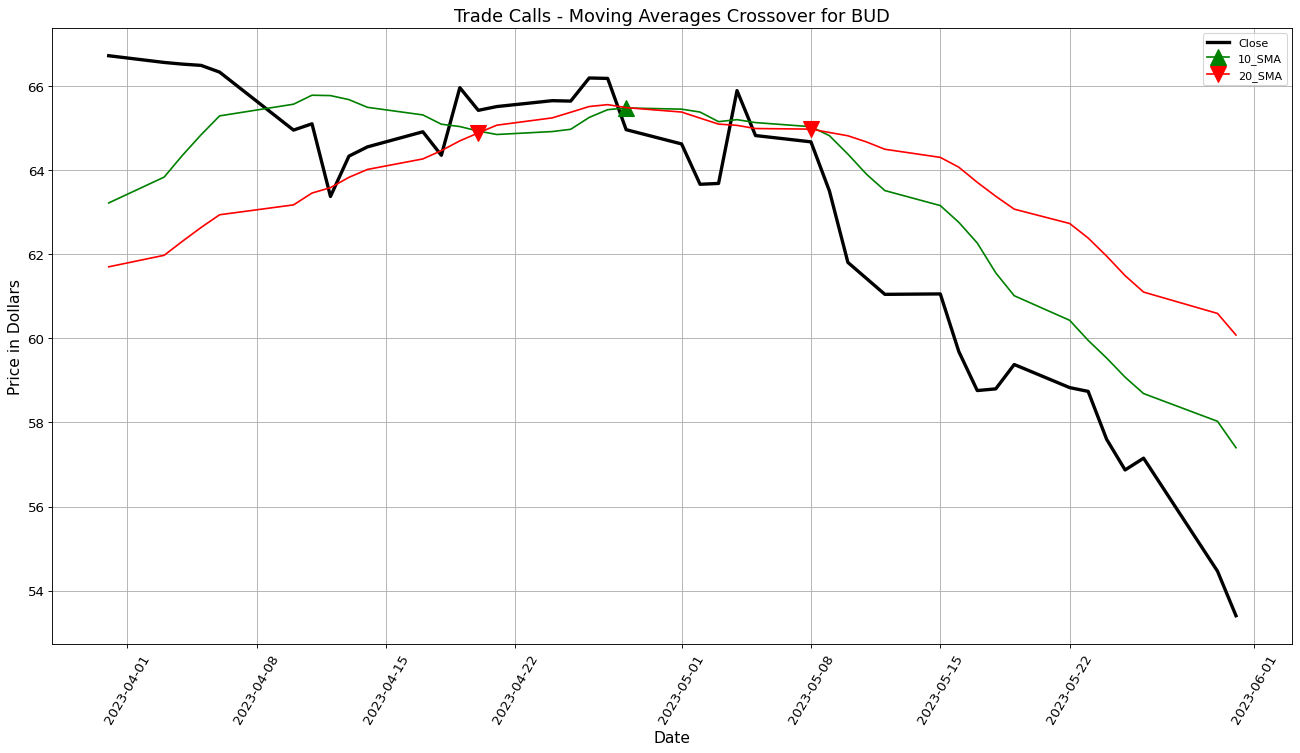

VADER sentiment score to generate trading signals
Trade Call for 2023-04-03 is Sell.
Trade Call for 2023-04-07 is Buy.
Trade Call for 2023-04-26 is Sell.
Trade Call for 2023-04-28 is Sell.
Trade Call for 2023-04-30 is Sell.
Trade Call for 2023-05-06 is Sell.
Trade Call for 2023-05-07 is Sell.
Trade Call for 2023-05-08 is Sell.
Trade Call for 2023-05-09 is Sell.
Trade Call for 2023-05-10 is Sell.
Trade Call for 2023-05-11 is Sell.
Trade Call for 2023-05-12 is Sell.
Trade Call for 2023-05-15 is Sell.
Trade Call for 2023-05-18 is Sell.
Trade Call for 2023-05-21 is Sell.
Trade Call for 2023-05-26 is Buy.
Trade Call for 2023-05-27 is Sell.
Trade Call for 2023-05-31 is Sell.
Using VADER sentiment


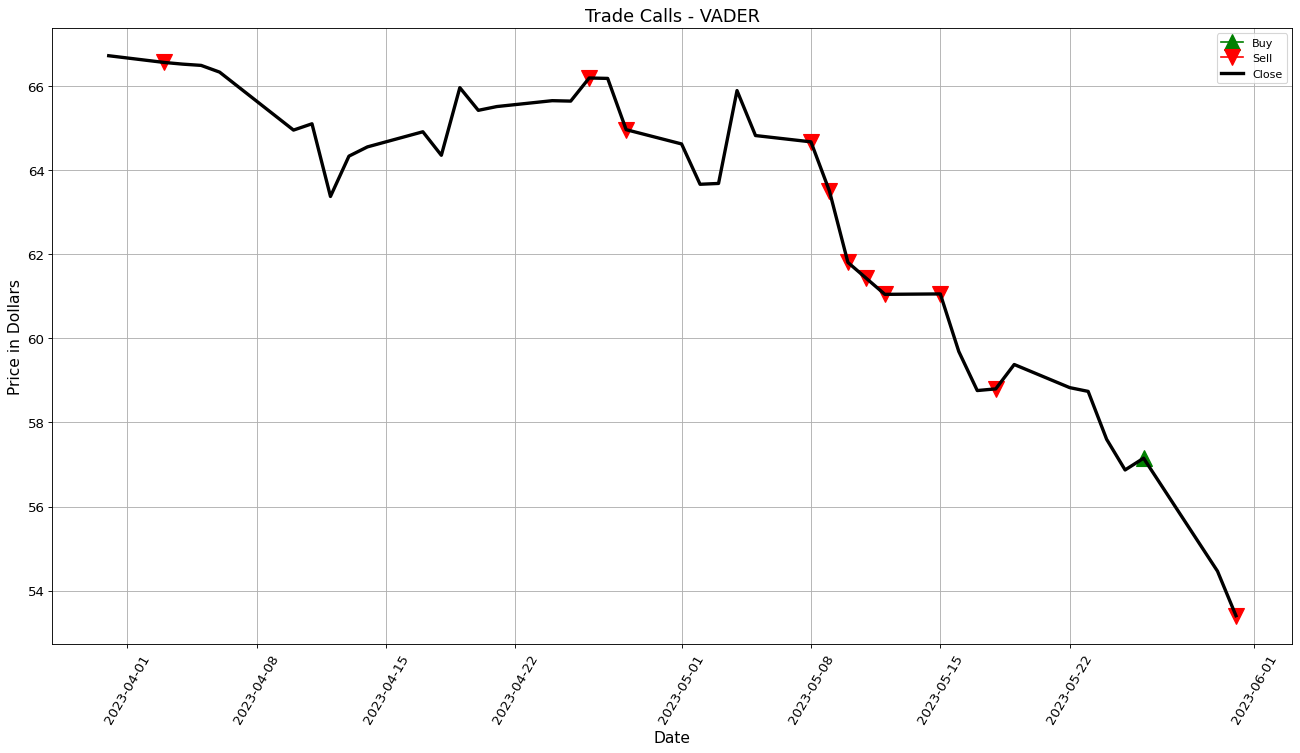

Using VADER sentiment and the simple moving average strategy


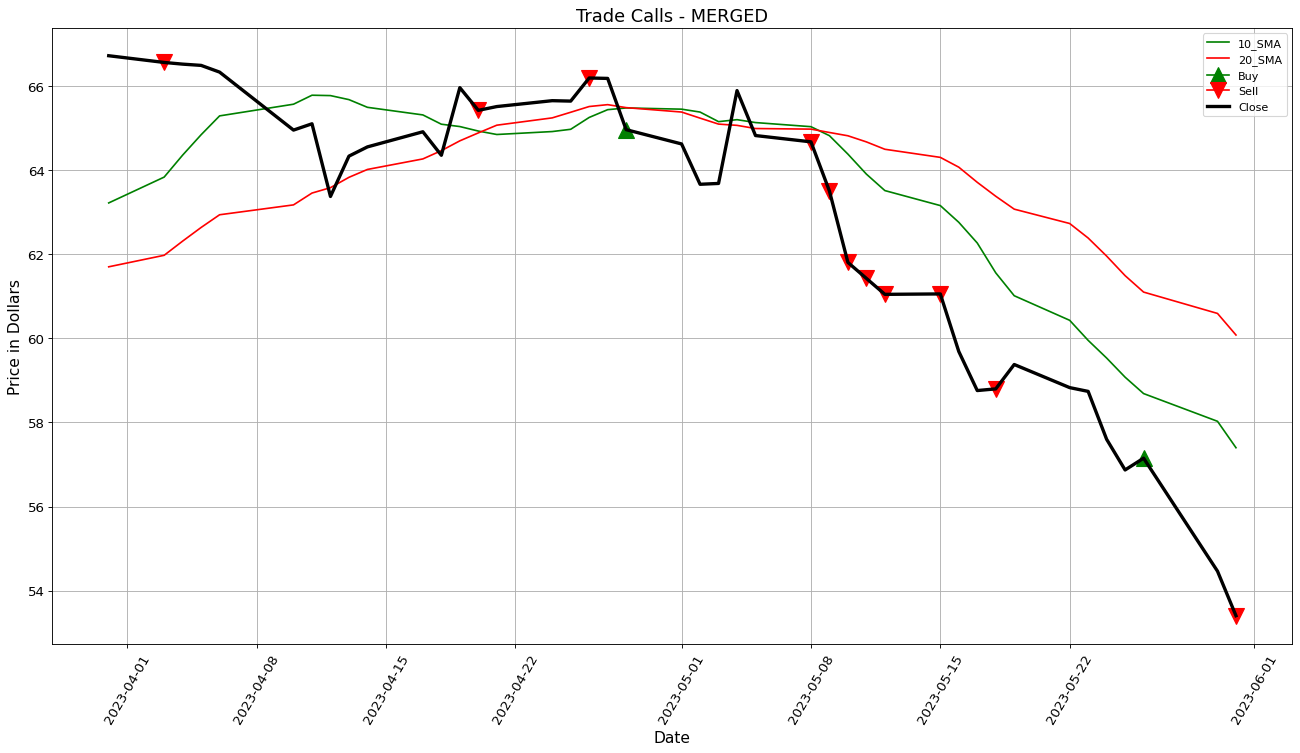

In [43]:
# for 10SMA and 20SMA: 

# total on twitter

#all together

df1 = pd.read_csv("BUD_0331_0412.csv")
df2 = pd.read_csv("BUD_0427_0503.csv")
df3 = pd.read_csv("BUD_0501_0531.csv")
pdList = [df1, df2, df3]  # List of your dataframes
df = pd.concat(pdList)
df['created_at'] = pd.to_datetime(df['created_at'])-  pd.to_timedelta(4, unit='h')
df = df.sort_values(by=['created_at']).reset_index(drop = True)

#twitter

new_df = df[(df['text'].notna())&(df['platform']=='twitter')].reset_index(drop = True)
n = len(new_df['text'])

compound = []
date = []
for i in range(n):
#     print(i, sentiment_analyzer_scores(feeds['text'][i])['compound'])
    compound.append(sentiment_analyzer_scores(new_df['text'][i])['compound'])
    date.append(new_df['created_at'][i].date())
    
new_df['Sentiment Score'] = compound
new_df['date'] = date

new_df['Sentiment Score'] = compound
new_df['date'] = date
showdrop(data2[data2.index>='2023-03-31'], '2023-06-01',new_df,'10_SMA','20_SMA')